In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
tf.__version__

'2.10.0'

In [2]:
listing_data = pd.read_csv('bukken_data_coordinates_fukuoka.csv', index_col=0)
listing_data.reset_index(inplace = True, drop = True)
print(listing_data.shape)
listing_data[372:374]

(8832, 18)


,Link,Full address,Latitude,Longitude,Prefecture,City,Ward,Neighborhood,Floor plan,Area m2,Balcony m2,Construction year,Floor,Highest floor,Building type,Closest station (min),Number of stations,Price
372,https://suumo.jp/ms/chuko/fukuoka/sc_kurume/nc...,福岡県久留米市善導寺町与田,33.321331,130.603592,福岡,久留米,善導寺町与,善導寺町与田,3LDK,70.08,0.00,1997,5,6.0,陸屋根,9.0,1.0,1380万円
373,https://suumo.jp/ms/chuko/fukuoka/sc_kitakyush...,福岡県北九州市小倉北区熊本３,33.867798,130.893738,福岡,北九州,小倉北,熊本３,5DK,87.80,9.39,1991,4-5,4.0,SRC14階地下,15.0,3.0,1380万円


# Cleaning data

## Remove uncessary columns for model

In [3]:
#listing_data = listing_data.drop(['Link', 'Full address', 'Prefecture', 'City', 'Ward', 'Neighborhood'], axis=1)
listing_data = listing_data.drop(['Full address', 'Prefecture', 'City', 'Ward', 'Neighborhood'], axis=1)
listing_data.tail(1)

,Link,Latitude,Longitude,Floor plan,Area m2,Balcony m2,Construction year,Floor,Highest floor,Building type,Closest station (min),Number of stations,Price
8831,https://suumo.jp/ms/chuko/fukuoka/sc_fukuokash...,33.662354,130.418076,2LDK,107.74,11.92,2019,43,46.0,RC,32.0,2.0,1億円


## Floor plan

### Simplify categories

In [4]:
listing_data['Floor plan'].unique()

array(['4LDK', '3LDK', '2LDK', '2LDK+S（納戸）', '3DK', '2DK', '1LDK',
       '3LDK+S（納戸）', '1LDK+S（納戸）', '4LDK+S（納戸）', '5LDK', '1DK', 'ワンルーム',
       '4DK', '4K', '2K', '5DK', '4DK+2S（納戸）', '3LDK+2S（納戸）', '3LK+S（納戸）',
       '1K', '5DK+S（納戸）', '3K', '3DK+S（納戸）', '5LDK+S（納戸）', '2LDK+2S（納戸）',
       '2LK', '2DK+S（納戸）', '4LDK+2S（納戸）', '1ワンルーム'], dtype=object)

In [5]:
listing_data['Floor plan'] = listing_data['Floor plan'].replace({'1ワンルーム', 'ワンルーム'}, '1R')

In [6]:
# listing_data['Type'] = test.str.replace('（納戸）', '')
listing_data['Floor plan'] = listing_data['Floor plan'].str.replace('\+[0-9]?S（納戸）', '', regex = True)

In [7]:
listing_data['Floor plan'].unique()

array(['4LDK', '3LDK', '2LDK', '3DK', '2DK', '1LDK', '5LDK', '1DK', '1R',
       '4DK', '4K', '2K', '5DK', '3LK', '1K', '3K', '2LK'], dtype=object)

In [8]:
types = list(listing_data['Floor plan'].unique())
types.sort()
types

['1DK',
 '1K',
 '1LDK',
 '1R',
 '2DK',
 '2K',
 '2LDK',
 '2LK',
 '3DK',
 '3K',
 '3LDK',
 '3LK',
 '4DK',
 '4K',
 '4LDK',
 '5DK',
 '5LDK']

In [9]:
#types.extend(['1DK+S','1DK+2S','1LDK+2S','1LK','1LK+S','1LK+2S', '2DK+2S', '2LK+S','2LK+2S', '3DK+2S', '3LK', '3LK+2S', '4DK+S', '4LK', '4LK+S','4LK+2S', '5DK+2S', '5LK', '5LK+S','5LK+2S','5LDK+2S'])
types.extend(['1LK', '3LK','4LK', '5LK'])
types.sort()
types

['1DK',
 '1K',
 '1LDK',
 '1LK',
 '1R',
 '2DK',
 '2K',
 '2LDK',
 '2LK',
 '3DK',
 '3K',
 '3LDK',
 '3LK',
 '3LK',
 '4DK',
 '4K',
 '4LDK',
 '4LK',
 '5DK',
 '5LDK',
 '5LK']

### One hot encoding

In [10]:
mapping = dict()

In [11]:
for i, b_type in enumerate(types):
    mapping[b_type]=b_type

In [12]:
listing_data['Floor plan'] = listing_data['Floor plan'].map(mapping)
listing_data = pd.get_dummies(listing_data, columns=['Floor plan'], prefix='', prefix_sep='')
listing_data.head()

,Link,Latitude,Longitude,Area m2,Balcony m2,Construction year,Floor,Highest floor,Building type,Closest station (min),...,2LK,3DK,3K,3LDK,3LK,4DK,4K,4LDK,5DK,5LDK
0,https://suumo.jp/ms/chuko/fukuoka/sc_kitakyush...,33.949905,130.973129,75.96,12.75,1983,2,5.0,RC,4.0,...,0,0,0,0,0,0,0,1,0,0
1,https://suumo.jp/ms/chuko/fukuoka/sc_fukuokash...,33.558590,130.435898,63.57,9.79,1976,5,5.0,RC,13.0,...,0,0,0,1,0,0,0,0,0,0
2,https://suumo.jp/ms/chuko/fukuoka/sc_fukuokash...,33.572346,130.449570,60.61,8.10,1983,4,5.0,RC,24.0,...,0,0,0,1,0,0,0,0,0,0
3,https://suumo.jp/ms/chuko/fukuoka/sc_kitakyush...,33.890411,130.766708,52.66,8.24,1986,2,7.0,RC,1.0,...,0,0,0,0,0,0,0,0,0,0
4,https://suumo.jp/ms/chuko/fukuoka/sc_kitakyush...,33.902637,130.804901,55.18,5.41,1979,3,5.0,RC,3.0,...,0,0,0,0,0,0,0,0,0,0


## Building type

In [13]:
listing_data['Building type'].unique()

array(['RC', 'SRC', 'SRC一部RC', '鉄筋コンクリート造', 'RC一部SRC', 'SRC14階地下',
       'RC5階地下', 'RC11階地下', 'RC14階地下', 'RC4階地下', 'RC10階地下', 'RC27階地下',
       'RC6階地下', 'RC7階地下', '陸屋根', '鉄骨', 'RC12階地下', '木造', 'RC一部RC',
       'RC31階地下', 'SRC10階地下', 'SRC11階地下', 'RC3階地下', 'RC8階地下', 'SRC12階地下',
       'RC9階地下', 'RC一部鉄骨', 'RC15階地下', 'RC35階地下一部鉄骨', '鉄骨一部RC',
       'SRC14階地下一部RC', 'SRC40階地下', 'SRC一部PC', 'SRC9階地下', 'RC13階地下',
       'ＳＲＣ造+ＲＣ造', 'SRC13階地下', 'SRC、RC造', 'RC7階地下一部RC', 'SRC・RC造',
       'SRC8階地下一部RC', 'SRC8階地下', 'SRC一部SRC', 'PC', 'RC3階地下一部RC', 'HPC',
       'SCR-RC', 'RC6階地下一部RC', 'SRC15階地下', 'SRC25階地下', 'SRC39階地下',
       'SRC41階地下', 'RC22階地下', 'PC6階地下', 'RC28階地下', 'RC5階地下一部RC',
       'SRC39階地下一部SRC', 'RC29階地下一部鉄骨', 'RC29階地下', 'RC40階地下', 'RC25階地下'],
      dtype=object)

In [14]:
listing_data['Building type'] = listing_data['Building type'].str.replace(r'\d+階', '', regex = True)
listing_data['Building type'] = listing_data['Building type'].str.replace('ＳＲＣ', 'SRC')
listing_data['Building type'] = listing_data['Building type'].str.replace('ＲＣ', 'RC')
listing_data['Building type'] = listing_data['Building type'].str.replace('地下', '')
listing_data['Building type'] = listing_data['Building type'].str.replace('造', '')
listing_data['Building type'] = listing_data['Building type'].str.replace('鉄骨', 'S')
listing_data['Building type'] = listing_data['Building type'].str.replace('RC一部RC', 'RC')
listing_data['Building type'] = listing_data['Building type'].str.replace('SRC一部SRC', 'SRC')
listing_data['Building type'] = listing_data['Building type'].str.replace('PC一部PC', 'PC')
listing_data['Building type'] = listing_data['Building type'].str.replace('鉄筋コンクリート', 'RC')
listing_data['Building type'] = listing_data['Building type'].str.replace('一部', '+')
listing_data['Building type'] = listing_data['Building type'].str.replace('、', '+')
listing_data['Building type'] = listing_data['Building type'].str.replace('・', '+')
listing_data['Building type'] = listing_data['Building type'].str.replace('-', '+')
listing_data['Building type'] = listing_data['Building type'].str.replace('-', '+')
listing_data['Building type'].unique()

array(['RC', 'SRC', 'RC+SRC', '陸屋根', 'S', '木', 'RC+S', 'S+RC', 'SRC+PC',
       'SRC+RC', 'PC', 'HPC', 'SCR+RC'], dtype=object)

In [15]:
b_mapping = dict()
b_types = list(listing_data['Building type'].unique())
for i, e in enumerate(b_types):
    b_mapping[e]=e

In [16]:
listing_data['Building type'] = listing_data['Building type'].map(b_mapping)
listing_data = pd.get_dummies(listing_data, columns=['Building type'], prefix='', prefix_sep='')
listing_data.head(3)

,Link,Latitude,Longitude,Area m2,Balcony m2,Construction year,Floor,Highest floor,Closest station (min),Number of stations,...,RC+S,RC+SRC,S,S+RC,SCR+RC,SRC,SRC+PC,SRC+RC,木,陸屋根
0,https://suumo.jp/ms/chuko/fukuoka/sc_kitakyush...,33.949905,130.973129,75.96,12.75,1983,2,5.0,4.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,https://suumo.jp/ms/chuko/fukuoka/sc_fukuokash...,33.558590,130.435898,63.57,9.79,1976,5,5.0,13.0,3.0,...,0,0,0,0,0,0,0,0,0,0
2,https://suumo.jp/ms/chuko/fukuoka/sc_fukuokash...,33.572346,130.449570,60.61,8.10,1983,4,5.0,24.0,3.0,...,0,0,0,0,0,0,0,0,0,0


## Price

In [18]:
listing_data['Price'].describe().transpose()

count       8832
unique       523
top       2480万円
freq         164
Name: Price, dtype: object

In [23]:
listing_data.iloc[listing_data['Price'].idxmax()]['Link']

'https://suumo.jp/ms/chuko/fukuoka/sc_fukuokashichuo/nc_98026235/'

In [20]:
def remove_thousands(price):
    try:
        man = price.index('万')
        return price[:man]
    except:
        return price

listing_data['Price'] = listing_data['Price'].str.replace('億円', '0000')
listing_data['Price'] = listing_data['Price'].str.replace('億', '')
listing_data['Price'] = listing_data['Price'].str.replace('円', '')
listing_data['Price'] = listing_data['Price'].apply(remove_thousands)
listing_data['Price'] = listing_data['Price'].astype('int64')

In [21]:
listing_data['Price'].describe()

count     8832.000000
mean      2286.141418
std       1487.224437
min        100.000000
25%       1580.000000
50%       2099.000000
75%       2749.000000
max      45000.000000
Name: Price, dtype: float64

## Floor

In [24]:
listing_data['Floor'].unique()

array(['2', '5', '4', '3', '8', '6', '1', '11', '7', '9', '12', '15',
       '13', '10', '14', '16', '20', '33', '22', '37', '36', '43', '19',
       '4-5', '6-8', 'B1', '1-2', '1-3', '35', '31', '21', '25', '41',
       'A', '7-8', '9-10', '1-B1', '24', '6-7', '34', '17', 'B1-1', '23',
       '8-9', '28', '27', '18', '26', '44'], dtype=object)

In [25]:
def cleanup(x):
    x=str(x)
    try: 
        return x[0:x.index('-')]
    except ValueError:
        return x


#listing_data['Floor'] = listing_data['Floor'].str.replace('-(B)?[0-9][0-9]?', '', regex=True)
#listing_data['Floor'] = listing_data['Floor'].apply(lambda x: try: x[:x.index('-')] except ValueError: x)
listing_data['Floor'] = listing_data['Floor'].apply(cleanup)
listing_data['Floor'] = listing_data['Floor'].apply(lambda x: -1 if(x[0]=='B') else x)
listing_data = listing_data[listing_data['Floor']!='A']
listing_data['Floor'] = listing_data['Floor'].astype('int8')
listing_data['Floor'].unique()

array([ 2,  5,  4,  3,  8,  6,  1, 11,  7,  9, 12, 15, 13, 10, 14, 16, 20,
       33, 22, 37, 36, 43, 19, -1, 35, 31, 21, 25, 41, 24, 34, 17, 23, 28,
       27, 18, 26, 44], dtype=int8)

In [30]:
listing_data['Closest station (min)'] = listing_data['Closest station (min)'].astype('uint8')
listing_data['Number of stations'] = listing_data['Number of stations'].astype('uint8')
listing_data['Number of stations'] = listing_data['Number of stations'].astype('uint8')
listing_data['Highest floor'] = listing_data['Highest floor'].astype('uint8')

# Model creation

In [31]:
listing_data = listing_data.drop('Link', axis=1)
listing_data.dtypes

Latitude                 float64
Longitude                float64
Area m2                  float64
Balcony m2               float64
Construction year          int64
Floor                       int8
Highest floor              uint8
Closest station (min)      uint8
Number of stations         uint8
Price                      int64
1DK                        uint8
1K                         uint8
1LDK                       uint8
1R                         uint8
2DK                        uint8
2K                         uint8
2LDK                       uint8
2LK                        uint8
3DK                        uint8
3K                         uint8
3LDK                       uint8
3LK                        uint8
4DK                        uint8
4K                         uint8
4LDK                       uint8
5DK                        uint8
5LDK                       uint8
HPC                        uint8
PC                         uint8
RC                         uint8
RC+S      

## Train and test set

In [33]:
train_dataset = listing_data.sample(frac=0.8, random_state=0)
test_dataset = listing_data.drop(train_dataset.index)

In [35]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Price')
test_labels = test_features.pop('Price')

In [36]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Latitude,33.634637,0.143737
Longitude,130.513562,0.189524
Area m2,72.287837,16.592785
Balcony m2,12.771101,8.773028
Construction year,1992.368063,11.530991
Floor,5.172282,3.849927
Highest floor,8.857305,4.567895
Closest station (min),9.272225,7.664950
Number of stations,2.307899,0.845851
Price,2293.848245,1512.964056


## Data normalization

In [ ]:
normalized_features = np.array(train_features[['Latitude', 'Longitude', 'Area m2', 'Balcony m2', 'Construction year', 'Floor', 'Highest floor', 'Closest station (min)', 'Number of stations' ]])

In [37]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [38]:
#normalizer.adapt(normalized_features)
normalizer.adapt(np.array(train_features))

In [39]:
print(normalizer.mean.numpy())

[[3.3634632e+01 1.3051355e+02 7.2287811e+01 1.2771100e+01 1.9923678e+03
  5.1722817e+00 8.8573036e+00 9.2722321e+00 2.3078995e+00 3.9637587e-03
  5.3793872e-03 5.3086080e-02 9.4847074e-03 8.9184623e-03 4.2468859e-04
  1.9875421e-01 2.8312567e-04 1.8120049e-02 4.2468854e-04 5.0056618e-01
  0.0000000e+00 1.0475645e-02 2.8312567e-04 1.8417327e-01 8.4937713e-04
  4.8131361e-03 1.4156282e-04 8.4937696e-04 7.0866364e-01 1.5571913e-03
  2.1234420e-03 9.9093968e-04 1.4156284e-04 1.4156284e-04 2.8001136e-01
  1.4156285e-04 1.4156282e-03 3.6806331e-03 1.4156289e-04]]


In [40]:
#first = np.array(train_features[['Latitude', 'Longitude', 'Area m2', 'Balcony m2', 'Construction year', 'Floor', 'Highest floor', 'Closest station (min)', 'Number of stations' ]][:1])
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  33.57  130.45   58.02    7.   1984.      4.      5.      3.      2.
     0.      0.      0.      0.      0.      0.      1.      0.      0.
     0.      0.      0.      0.      0.      0.      0.      0.      0.
     0.      1.      0.      0.      0.      0.      0.      0.      0.
     0.      0.      0.  ]]

Normalized: [[-0.43 -0.35 -0.86 -0.66 -0.73 -0.3  -0.84 -0.82 -0.36 -0.06 -0.07 -0.24
  -0.1  -0.09 -0.02  2.01 -0.02 -0.14 -0.02 -1.    0.   -0.1  -0.02 -0.48
  -0.03 -0.07 -0.01 -0.03  0.64 -0.04 -0.05 -0.03 -0.01 -0.01 -0.62 -0.01
  -0.04 -0.06 -0.01]]


## DNN settings

In [124]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dropout(rate=.2),
      layers.Dense(64, activation='relu'),
      layers.Dropout(rate=.2), 
      layers.Dense(64, activation='relu'),
      layers.Dropout(rate=.2),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_percentage_error',optimizer=tf.keras.optimizers.Adam(0.01))
    return model

In [125]:
price_reduction_model = build_and_compile_model(normalizer)

In [126]:
price_reduction_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 39)               79        
 n)                                                              
                                                                 
 dropout (Dropout)           (None, 39)                0         
                                                                 
 dense_15 (Dense)            (None, 64)                2560      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                      

In [127]:
%%time
history = price_reduction_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=2, epochs=5000)

Epoch 1/5000
177/177 - 1s - loss: 51.2102 - val_loss: 26.9387 - 1s/epoch - 8ms/step
Epoch 2/5000
177/177 - 1s - loss: 31.2032 - val_loss: 26.2021 - 507ms/epoch - 3ms/step
Epoch 3/5000
177/177 - 1s - loss: 30.5017 - val_loss: 25.5138 - 521ms/epoch - 3ms/step
Epoch 4/5000
177/177 - 1s - loss: 30.1048 - val_loss: 26.2777 - 507ms/epoch - 3ms/step
Epoch 5/5000
177/177 - 1s - loss: 30.0334 - val_loss: 25.0731 - 550ms/epoch - 3ms/step
Epoch 6/5000
177/177 - 1s - loss: 30.0489 - val_loss: 25.6702 - 572ms/epoch - 3ms/step
Epoch 7/5000
177/177 - 1s - loss: 29.1476 - val_loss: 25.0333 - 636ms/epoch - 4ms/step
Epoch 8/5000
177/177 - 1s - loss: 28.9130 - val_loss: 24.3769 - 565ms/epoch - 3ms/step
Epoch 9/5000
177/177 - 1s - loss: 29.0888 - val_loss: 24.7950 - 596ms/epoch - 3ms/step
Epoch 10/5000
177/177 - 1s - loss: 29.2527 - val_loss: 25.3054 - 544ms/epoch - 3ms/step
Epoch 11/5000
177/177 - 0s - loss: 29.2625 - val_loss: 24.7620 - 497ms/epoch - 3ms/step
Epoch 12/5000
177/177 - 1s - loss: 29.1891 -

Epoch 95/5000
177/177 - 1s - loss: 27.5990 - val_loss: 22.5575 - 505ms/epoch - 3ms/step
Epoch 96/5000
177/177 - 1s - loss: 26.9075 - val_loss: 23.0609 - 501ms/epoch - 3ms/step
Epoch 97/5000
177/177 - 0s - loss: 27.7132 - val_loss: 22.6652 - 500ms/epoch - 3ms/step
Epoch 98/5000
177/177 - 1s - loss: 27.5120 - val_loss: 22.5897 - 517ms/epoch - 3ms/step
Epoch 99/5000
177/177 - 1s - loss: 27.6534 - val_loss: 23.7137 - 502ms/epoch - 3ms/step
Epoch 100/5000
177/177 - 1s - loss: 27.1063 - val_loss: 23.7076 - 502ms/epoch - 3ms/step
Epoch 101/5000
177/177 - 1s - loss: 27.4502 - val_loss: 22.7443 - 500ms/epoch - 3ms/step
Epoch 102/5000
177/177 - 1s - loss: 27.6865 - val_loss: 23.9280 - 517ms/epoch - 3ms/step
Epoch 103/5000
177/177 - 1s - loss: 27.8165 - val_loss: 24.8101 - 517ms/epoch - 3ms/step
Epoch 104/5000
177/177 - 1s - loss: 27.3822 - val_loss: 23.0600 - 517ms/epoch - 3ms/step
Epoch 105/5000
177/177 - 1s - loss: 27.4523 - val_loss: 23.9948 - 502ms/epoch - 3ms/step
Epoch 106/5000
177/177 - 1

177/177 - 1s - loss: 27.1164 - val_loss: 23.3404 - 517ms/epoch - 3ms/step
Epoch 188/5000
177/177 - 0s - loss: 26.9657 - val_loss: 22.1674 - 499ms/epoch - 3ms/step
Epoch 189/5000
177/177 - 1s - loss: 26.3264 - val_loss: 22.5979 - 517ms/epoch - 3ms/step
Epoch 190/5000
177/177 - 1s - loss: 26.8305 - val_loss: 22.0326 - 502ms/epoch - 3ms/step
Epoch 191/5000
177/177 - 1s - loss: 26.7928 - val_loss: 23.0434 - 522ms/epoch - 3ms/step
Epoch 192/5000
177/177 - 1s - loss: 26.7641 - val_loss: 21.7694 - 511ms/epoch - 3ms/step
Epoch 193/5000
177/177 - 1s - loss: 26.7389 - val_loss: 22.2499 - 502ms/epoch - 3ms/step
Epoch 194/5000
177/177 - 1s - loss: 26.3978 - val_loss: 23.0575 - 518ms/epoch - 3ms/step
Epoch 195/5000
177/177 - 1s - loss: 26.7984 - val_loss: 23.1037 - 517ms/epoch - 3ms/step
Epoch 196/5000
177/177 - 1s - loss: 26.5620 - val_loss: 22.6211 - 517ms/epoch - 3ms/step
Epoch 197/5000
177/177 - 1s - loss: 27.4647 - val_loss: 22.4952 - 502ms/epoch - 3ms/step
Epoch 198/5000
177/177 - 1s - loss: 

Epoch 280/5000
177/177 - 1s - loss: 26.9026 - val_loss: 22.3956 - 670ms/epoch - 4ms/step
Epoch 281/5000
177/177 - 1s - loss: 26.7234 - val_loss: 21.6322 - 658ms/epoch - 4ms/step
Epoch 282/5000
177/177 - 1s - loss: 26.2836 - val_loss: 22.1351 - 660ms/epoch - 4ms/step
Epoch 283/5000
177/177 - 1s - loss: 26.6700 - val_loss: 23.0636 - 689ms/epoch - 4ms/step
Epoch 284/5000
177/177 - 1s - loss: 26.3665 - val_loss: 22.0160 - 658ms/epoch - 4ms/step
Epoch 285/5000
177/177 - 1s - loss: 26.5431 - val_loss: 22.7169 - 674ms/epoch - 4ms/step
Epoch 286/5000
177/177 - 1s - loss: 26.9605 - val_loss: 23.4235 - 659ms/epoch - 4ms/step
Epoch 287/5000
177/177 - 1s - loss: 26.1085 - val_loss: 21.9086 - 658ms/epoch - 4ms/step
Epoch 288/5000
177/177 - 1s - loss: 26.6193 - val_loss: 22.3422 - 659ms/epoch - 4ms/step
Epoch 289/5000
177/177 - 1s - loss: 26.2405 - val_loss: 22.1235 - 674ms/epoch - 4ms/step
Epoch 290/5000
177/177 - 1s - loss: 26.6459 - val_loss: 22.2323 - 672ms/epoch - 4ms/step
Epoch 291/5000
177/17

177/177 - 1s - loss: 26.2417 - val_loss: 23.0620 - 691ms/epoch - 4ms/step
Epoch 373/5000
177/177 - 1s - loss: 25.8913 - val_loss: 21.2723 - 705ms/epoch - 4ms/step
Epoch 374/5000
177/177 - 1s - loss: 25.8898 - val_loss: 23.0564 - 688ms/epoch - 4ms/step
Epoch 375/5000
177/177 - 1s - loss: 25.8874 - val_loss: 21.9694 - 690ms/epoch - 4ms/step
Epoch 376/5000
177/177 - 1s - loss: 25.8486 - val_loss: 22.5822 - 689ms/epoch - 4ms/step
Epoch 377/5000
177/177 - 1s - loss: 26.0847 - val_loss: 22.5600 - 690ms/epoch - 4ms/step
Epoch 378/5000
177/177 - 1s - loss: 25.6870 - val_loss: 21.7241 - 689ms/epoch - 4ms/step
Epoch 379/5000
177/177 - 1s - loss: 25.8845 - val_loss: 21.3869 - 674ms/epoch - 4ms/step
Epoch 380/5000
177/177 - 1s - loss: 26.2860 - val_loss: 22.0819 - 675ms/epoch - 4ms/step
Epoch 381/5000
177/177 - 1s - loss: 25.9112 - val_loss: 22.0187 - 689ms/epoch - 4ms/step
Epoch 382/5000
177/177 - 1s - loss: 26.1137 - val_loss: 21.5415 - 689ms/epoch - 4ms/step
Epoch 383/5000
177/177 - 1s - loss: 

Epoch 465/5000
177/177 - 1s - loss: 25.5032 - val_loss: 21.9703 - 684ms/epoch - 4ms/step
Epoch 466/5000
177/177 - 1s - loss: 25.5256 - val_loss: 21.0785 - 692ms/epoch - 4ms/step
Epoch 467/5000
177/177 - 1s - loss: 25.0532 - val_loss: 21.5994 - 701ms/epoch - 4ms/step
Epoch 468/5000
177/177 - 1s - loss: 25.0589 - val_loss: 21.0873 - 684ms/epoch - 4ms/step
Epoch 469/5000
177/177 - 1s - loss: 25.3927 - val_loss: 21.6354 - 675ms/epoch - 4ms/step
Epoch 470/5000
177/177 - 1s - loss: 24.9128 - val_loss: 21.5446 - 688ms/epoch - 4ms/step
Epoch 471/5000
177/177 - 1s - loss: 25.7557 - val_loss: 21.4993 - 674ms/epoch - 4ms/step
Epoch 472/5000
177/177 - 1s - loss: 25.1569 - val_loss: 21.8703 - 690ms/epoch - 4ms/step
Epoch 473/5000
177/177 - 1s - loss: 25.1232 - val_loss: 21.1038 - 690ms/epoch - 4ms/step
Epoch 474/5000
177/177 - 1s - loss: 24.7685 - val_loss: 22.3437 - 687ms/epoch - 4ms/step
Epoch 475/5000
177/177 - 1s - loss: 25.5964 - val_loss: 21.4099 - 673ms/epoch - 4ms/step
Epoch 476/5000
177/17

177/177 - 1s - loss: 24.4905 - val_loss: 21.5811 - 671ms/epoch - 4ms/step
Epoch 558/5000
177/177 - 1s - loss: 25.2229 - val_loss: 21.6969 - 675ms/epoch - 4ms/step
Epoch 559/5000
177/177 - 1s - loss: 24.8889 - val_loss: 21.1209 - 706ms/epoch - 4ms/step
Epoch 560/5000
177/177 - 1s - loss: 24.7945 - val_loss: 21.0419 - 675ms/epoch - 4ms/step
Epoch 561/5000
177/177 - 1s - loss: 24.8107 - val_loss: 20.9568 - 691ms/epoch - 4ms/step
Epoch 562/5000
177/177 - 1s - loss: 24.9810 - val_loss: 21.1549 - 674ms/epoch - 4ms/step
Epoch 563/5000
177/177 - 1s - loss: 24.8175 - val_loss: 21.7842 - 675ms/epoch - 4ms/step
Epoch 564/5000
177/177 - 1s - loss: 24.6509 - val_loss: 22.5559 - 674ms/epoch - 4ms/step
Epoch 565/5000
177/177 - 1s - loss: 25.1817 - val_loss: 21.5455 - 691ms/epoch - 4ms/step
Epoch 566/5000
177/177 - 1s - loss: 25.2131 - val_loss: 22.5396 - 691ms/epoch - 4ms/step
Epoch 567/5000
177/177 - 1s - loss: 25.0838 - val_loss: 21.5109 - 690ms/epoch - 4ms/step
Epoch 568/5000
177/177 - 1s - loss: 

Epoch 650/5000
177/177 - 1s - loss: 25.0730 - val_loss: 21.1673 - 691ms/epoch - 4ms/step
Epoch 651/5000
177/177 - 1s - loss: 24.7382 - val_loss: 23.0334 - 690ms/epoch - 4ms/step
Epoch 652/5000
177/177 - 1s - loss: 24.5660 - val_loss: 21.2938 - 706ms/epoch - 4ms/step
Epoch 653/5000
177/177 - 1s - loss: 24.1926 - val_loss: 20.4268 - 706ms/epoch - 4ms/step
Epoch 654/5000
177/177 - 1s - loss: 24.7057 - val_loss: 20.9932 - 691ms/epoch - 4ms/step
Epoch 655/5000
177/177 - 1s - loss: 24.8090 - val_loss: 20.6453 - 706ms/epoch - 4ms/step
Epoch 656/5000
177/177 - 1s - loss: 24.6168 - val_loss: 22.3002 - 706ms/epoch - 4ms/step
Epoch 657/5000
177/177 - 1s - loss: 24.4357 - val_loss: 20.8168 - 707ms/epoch - 4ms/step
Epoch 658/5000
177/177 - 1s - loss: 24.6806 - val_loss: 23.3774 - 706ms/epoch - 4ms/step
Epoch 659/5000
177/177 - 1s - loss: 24.4810 - val_loss: 22.5950 - 691ms/epoch - 4ms/step
Epoch 660/5000
177/177 - 1s - loss: 24.5743 - val_loss: 21.0797 - 690ms/epoch - 4ms/step
Epoch 661/5000
177/17

177/177 - 1s - loss: 24.4620 - val_loss: 20.4763 - 706ms/epoch - 4ms/step
Epoch 743/5000
177/177 - 1s - loss: 24.0077 - val_loss: 20.7709 - 753ms/epoch - 4ms/step
Epoch 744/5000
177/177 - 1s - loss: 24.5656 - val_loss: 21.1262 - 722ms/epoch - 4ms/step
Epoch 745/5000
177/177 - 1s - loss: 24.6010 - val_loss: 21.7749 - 706ms/epoch - 4ms/step
Epoch 746/5000
177/177 - 1s - loss: 24.6688 - val_loss: 23.1185 - 690ms/epoch - 4ms/step
Epoch 747/5000
177/177 - 1s - loss: 24.1675 - val_loss: 21.7602 - 691ms/epoch - 4ms/step
Epoch 748/5000
177/177 - 1s - loss: 24.0976 - val_loss: 20.9812 - 706ms/epoch - 4ms/step
Epoch 749/5000
177/177 - 1s - loss: 24.7605 - val_loss: 20.7446 - 706ms/epoch - 4ms/step
Epoch 750/5000
177/177 - 1s - loss: 24.2086 - val_loss: 21.1194 - 691ms/epoch - 4ms/step
Epoch 751/5000
177/177 - 1s - loss: 24.0201 - val_loss: 22.6190 - 706ms/epoch - 4ms/step
Epoch 752/5000
177/177 - 1s - loss: 24.3689 - val_loss: 21.4929 - 706ms/epoch - 4ms/step
Epoch 753/5000
177/177 - 1s - loss: 

Epoch 835/5000
177/177 - 1s - loss: 24.2516 - val_loss: 21.5476 - 706ms/epoch - 4ms/step
Epoch 836/5000
177/177 - 1s - loss: 24.1386 - val_loss: 21.6004 - 706ms/epoch - 4ms/step
Epoch 837/5000
177/177 - 1s - loss: 24.4039 - val_loss: 20.5314 - 712ms/epoch - 4ms/step
Epoch 838/5000
177/177 - 1s - loss: 23.8714 - val_loss: 20.8307 - 706ms/epoch - 4ms/step
Epoch 839/5000
177/177 - 1s - loss: 24.0685 - val_loss: 21.4152 - 722ms/epoch - 4ms/step
Epoch 840/5000
177/177 - 1s - loss: 24.2531 - val_loss: 22.0091 - 706ms/epoch - 4ms/step
Epoch 841/5000
177/177 - 1s - loss: 24.0814 - val_loss: 21.2314 - 738ms/epoch - 4ms/step
Epoch 842/5000
177/177 - 1s - loss: 24.5861 - val_loss: 21.1304 - 736ms/epoch - 4ms/step
Epoch 843/5000
177/177 - 1s - loss: 23.6816 - val_loss: 23.3240 - 706ms/epoch - 4ms/step
Epoch 844/5000
177/177 - 1s - loss: 24.2408 - val_loss: 20.6432 - 706ms/epoch - 4ms/step
Epoch 845/5000
177/177 - 1s - loss: 23.6976 - val_loss: 20.3538 - 721ms/epoch - 4ms/step
Epoch 846/5000
177/17

177/177 - 1s - loss: 24.3675 - val_loss: 21.3742 - 706ms/epoch - 4ms/step
Epoch 928/5000
177/177 - 1s - loss: 24.0322 - val_loss: 20.5246 - 722ms/epoch - 4ms/step
Epoch 929/5000
177/177 - 1s - loss: 24.0593 - val_loss: 20.4410 - 815ms/epoch - 5ms/step
Epoch 930/5000
177/177 - 1s - loss: 24.0874 - val_loss: 20.5894 - 848ms/epoch - 5ms/step
Epoch 931/5000
177/177 - 1s - loss: 23.7768 - val_loss: 21.6579 - 706ms/epoch - 4ms/step
Epoch 932/5000
177/177 - 1s - loss: 24.1978 - val_loss: 22.8202 - 721ms/epoch - 4ms/step
Epoch 933/5000
177/177 - 1s - loss: 23.7427 - val_loss: 20.4394 - 723ms/epoch - 4ms/step
Epoch 934/5000
177/177 - 1s - loss: 24.0400 - val_loss: 20.6142 - 705ms/epoch - 4ms/step
Epoch 935/5000
177/177 - 1s - loss: 23.7682 - val_loss: 20.2751 - 706ms/epoch - 4ms/step
Epoch 936/5000
177/177 - 1s - loss: 23.8169 - val_loss: 21.0890 - 722ms/epoch - 4ms/step
Epoch 937/5000
177/177 - 1s - loss: 23.9672 - val_loss: 21.1617 - 706ms/epoch - 4ms/step
Epoch 938/5000
177/177 - 1s - loss: 

177/177 - 1s - loss: 23.8134 - val_loss: 20.5415 - 713ms/epoch - 4ms/step
Epoch 1020/5000
177/177 - 1s - loss: 24.3107 - val_loss: 20.8500 - 722ms/epoch - 4ms/step
Epoch 1021/5000
177/177 - 1s - loss: 24.0399 - val_loss: 20.5352 - 722ms/epoch - 4ms/step
Epoch 1022/5000
177/177 - 1s - loss: 23.8294 - val_loss: 21.3322 - 737ms/epoch - 4ms/step
Epoch 1023/5000
177/177 - 1s - loss: 24.2491 - val_loss: 20.2032 - 738ms/epoch - 4ms/step
Epoch 1024/5000
177/177 - 1s - loss: 23.6670 - val_loss: 20.5451 - 722ms/epoch - 4ms/step
Epoch 1025/5000
177/177 - 1s - loss: 24.0605 - val_loss: 20.9012 - 706ms/epoch - 4ms/step
Epoch 1026/5000
177/177 - 1s - loss: 24.0103 - val_loss: 21.2869 - 706ms/epoch - 4ms/step
Epoch 1027/5000
177/177 - 1s - loss: 24.0958 - val_loss: 21.5861 - 722ms/epoch - 4ms/step
Epoch 1028/5000
177/177 - 1s - loss: 24.1312 - val_loss: 20.5239 - 711ms/epoch - 4ms/step
Epoch 1029/5000
177/177 - 1s - loss: 23.9059 - val_loss: 20.7095 - 721ms/epoch - 4ms/step
Epoch 1030/5000
177/177 - 

Epoch 1111/5000
177/177 - 1s - loss: 24.2371 - val_loss: 20.4130 - 722ms/epoch - 4ms/step
Epoch 1112/5000
177/177 - 1s - loss: 23.7147 - val_loss: 21.1489 - 722ms/epoch - 4ms/step
Epoch 1113/5000
177/177 - 1s - loss: 23.7570 - val_loss: 19.7764 - 723ms/epoch - 4ms/step
Epoch 1114/5000
177/177 - 1s - loss: 24.0240 - val_loss: 21.9280 - 706ms/epoch - 4ms/step
Epoch 1115/5000
177/177 - 1s - loss: 23.7926 - val_loss: 20.9896 - 722ms/epoch - 4ms/step
Epoch 1116/5000
177/177 - 1s - loss: 23.5736 - val_loss: 20.0188 - 737ms/epoch - 4ms/step
Epoch 1117/5000
177/177 - 1s - loss: 23.4424 - val_loss: 20.3476 - 753ms/epoch - 4ms/step
Epoch 1118/5000
177/177 - 1s - loss: 23.8055 - val_loss: 20.4519 - 737ms/epoch - 4ms/step
Epoch 1119/5000
177/177 - 1s - loss: 23.2554 - val_loss: 19.8821 - 737ms/epoch - 4ms/step
Epoch 1120/5000
177/177 - 1s - loss: 23.5515 - val_loss: 20.5612 - 769ms/epoch - 4ms/step
Epoch 1121/5000
177/177 - 1s - loss: 23.3760 - val_loss: 20.6143 - 738ms/epoch - 4ms/step
Epoch 1122

177/177 - 1s - loss: 23.9952 - val_loss: 21.2273 - 786ms/epoch - 4ms/step
Epoch 1203/5000
177/177 - 1s - loss: 23.4712 - val_loss: 20.8822 - 737ms/epoch - 4ms/step
Epoch 1204/5000
177/177 - 1s - loss: 23.3634 - val_loss: 21.2291 - 733ms/epoch - 4ms/step
Epoch 1205/5000
177/177 - 1s - loss: 23.7610 - val_loss: 20.4713 - 738ms/epoch - 4ms/step
Epoch 1206/5000
177/177 - 1s - loss: 23.8164 - val_loss: 20.4693 - 722ms/epoch - 4ms/step
Epoch 1207/5000
177/177 - 1s - loss: 23.8050 - val_loss: 20.8109 - 724ms/epoch - 4ms/step
Epoch 1208/5000
177/177 - 1s - loss: 23.6767 - val_loss: 20.7647 - 722ms/epoch - 4ms/step
Epoch 1209/5000
177/177 - 1s - loss: 23.7727 - val_loss: 20.4301 - 721ms/epoch - 4ms/step
Epoch 1210/5000
177/177 - 1s - loss: 24.0346 - val_loss: 20.0711 - 722ms/epoch - 4ms/step
Epoch 1211/5000
177/177 - 1s - loss: 23.9527 - val_loss: 20.4441 - 722ms/epoch - 4ms/step
Epoch 1212/5000
177/177 - 1s - loss: 23.3472 - val_loss: 20.9350 - 722ms/epoch - 4ms/step
Epoch 1213/5000
177/177 - 

Epoch 1294/5000
177/177 - 1s - loss: 23.6563 - val_loss: 21.5477 - 720ms/epoch - 4ms/step
Epoch 1295/5000
177/177 - 1s - loss: 22.8630 - val_loss: 20.8382 - 737ms/epoch - 4ms/step
Epoch 1296/5000
177/177 - 1s - loss: 23.3047 - val_loss: 19.9784 - 738ms/epoch - 4ms/step
Epoch 1297/5000
177/177 - 1s - loss: 23.1809 - val_loss: 20.2890 - 743ms/epoch - 4ms/step
Epoch 1298/5000
177/177 - 1s - loss: 23.3064 - val_loss: 20.8840 - 737ms/epoch - 4ms/step
Epoch 1299/5000
177/177 - 1s - loss: 23.4407 - val_loss: 20.3437 - 724ms/epoch - 4ms/step
Epoch 1300/5000
177/177 - 1s - loss: 23.8554 - val_loss: 21.1428 - 735ms/epoch - 4ms/step
Epoch 1301/5000
177/177 - 1s - loss: 23.8002 - val_loss: 20.8797 - 722ms/epoch - 4ms/step
Epoch 1302/5000
177/177 - 1s - loss: 23.5999 - val_loss: 20.3673 - 722ms/epoch - 4ms/step
Epoch 1303/5000
177/177 - 1s - loss: 23.7030 - val_loss: 20.2678 - 728ms/epoch - 4ms/step
Epoch 1304/5000
177/177 - 1s - loss: 23.3017 - val_loss: 19.7877 - 716ms/epoch - 4ms/step
Epoch 1305

177/177 - 1s - loss: 23.4381 - val_loss: 20.8480 - 738ms/epoch - 4ms/step
Epoch 1386/5000
177/177 - 1s - loss: 23.2889 - val_loss: 20.2750 - 737ms/epoch - 4ms/step
Epoch 1387/5000
177/177 - 1s - loss: 22.8545 - val_loss: 20.3314 - 722ms/epoch - 4ms/step
Epoch 1388/5000
177/177 - 1s - loss: 22.8917 - val_loss: 20.0632 - 737ms/epoch - 4ms/step
Epoch 1389/5000
177/177 - 1s - loss: 23.0252 - val_loss: 20.2091 - 738ms/epoch - 4ms/step
Epoch 1390/5000
177/177 - 1s - loss: 23.2816 - val_loss: 20.6049 - 737ms/epoch - 4ms/step
Epoch 1391/5000
177/177 - 1s - loss: 23.3683 - val_loss: 20.4745 - 722ms/epoch - 4ms/step
Epoch 1392/5000
177/177 - 1s - loss: 23.3612 - val_loss: 20.9091 - 722ms/epoch - 4ms/step
Epoch 1393/5000
177/177 - 1s - loss: 23.4078 - val_loss: 21.2711 - 722ms/epoch - 4ms/step
Epoch 1394/5000
177/177 - 1s - loss: 23.2908 - val_loss: 20.0005 - 754ms/epoch - 4ms/step
Epoch 1395/5000
177/177 - 1s - loss: 22.9049 - val_loss: 21.5582 - 721ms/epoch - 4ms/step
Epoch 1396/5000
177/177 - 

Epoch 1477/5000
177/177 - 1s - loss: 23.4915 - val_loss: 20.2577 - 722ms/epoch - 4ms/step
Epoch 1478/5000
177/177 - 1s - loss: 22.9554 - val_loss: 19.8847 - 714ms/epoch - 4ms/step
Epoch 1479/5000
177/177 - 1s - loss: 23.3424 - val_loss: 19.9031 - 737ms/epoch - 4ms/step
Epoch 1480/5000
177/177 - 1s - loss: 23.5914 - val_loss: 20.3153 - 738ms/epoch - 4ms/step
Epoch 1481/5000
177/177 - 1s - loss: 23.1219 - val_loss: 20.3018 - 738ms/epoch - 4ms/step
Epoch 1482/5000
177/177 - 1s - loss: 23.0013 - val_loss: 20.4045 - 722ms/epoch - 4ms/step
Epoch 1483/5000
177/177 - 1s - loss: 23.0681 - val_loss: 20.4924 - 721ms/epoch - 4ms/step
Epoch 1484/5000
177/177 - 1s - loss: 23.4622 - val_loss: 20.4601 - 726ms/epoch - 4ms/step
Epoch 1485/5000
177/177 - 1s - loss: 22.9774 - val_loss: 20.8246 - 717ms/epoch - 4ms/step
Epoch 1486/5000
177/177 - 1s - loss: 23.6886 - val_loss: 20.0642 - 737ms/epoch - 4ms/step
Epoch 1487/5000
177/177 - 1s - loss: 23.4583 - val_loss: 21.6862 - 722ms/epoch - 4ms/step
Epoch 1488

177/177 - 1s - loss: 23.2880 - val_loss: 20.7741 - 722ms/epoch - 4ms/step
Epoch 1569/5000
177/177 - 1s - loss: 23.3284 - val_loss: 19.9059 - 738ms/epoch - 4ms/step
Epoch 1570/5000
177/177 - 1s - loss: 22.5061 - val_loss: 20.1643 - 722ms/epoch - 4ms/step
Epoch 1571/5000
177/177 - 1s - loss: 23.3943 - val_loss: 20.6737 - 724ms/epoch - 4ms/step
Epoch 1572/5000
177/177 - 1s - loss: 23.3940 - val_loss: 21.6135 - 721ms/epoch - 4ms/step
Epoch 1573/5000
177/177 - 1s - loss: 23.1712 - val_loss: 20.3929 - 722ms/epoch - 4ms/step
Epoch 1574/5000
177/177 - 1s - loss: 23.3940 - val_loss: 20.5879 - 738ms/epoch - 4ms/step
Epoch 1575/5000
177/177 - 1s - loss: 23.3648 - val_loss: 20.7837 - 722ms/epoch - 4ms/step
Epoch 1576/5000
177/177 - 1s - loss: 22.5967 - val_loss: 20.2487 - 737ms/epoch - 4ms/step
Epoch 1577/5000
177/177 - 1s - loss: 23.0105 - val_loss: 20.9794 - 732ms/epoch - 4ms/step
Epoch 1578/5000
177/177 - 1s - loss: 23.4611 - val_loss: 20.0151 - 721ms/epoch - 4ms/step
Epoch 1579/5000
177/177 - 

Epoch 1660/5000
177/177 - 1s - loss: 23.0360 - val_loss: 20.1439 - 737ms/epoch - 4ms/step
Epoch 1661/5000
177/177 - 1s - loss: 23.0872 - val_loss: 20.9734 - 738ms/epoch - 4ms/step
Epoch 1662/5000
177/177 - 1s - loss: 23.3732 - val_loss: 21.4903 - 722ms/epoch - 4ms/step
Epoch 1663/5000
177/177 - 1s - loss: 23.2422 - val_loss: 20.5520 - 738ms/epoch - 4ms/step
Epoch 1664/5000
177/177 - 1s - loss: 22.5822 - val_loss: 20.2862 - 737ms/epoch - 4ms/step
Epoch 1665/5000
177/177 - 1s - loss: 22.9427 - val_loss: 19.7858 - 753ms/epoch - 4ms/step
Epoch 1666/5000
177/177 - 1s - loss: 23.1878 - val_loss: 20.0306 - 722ms/epoch - 4ms/step
Epoch 1667/5000
177/177 - 1s - loss: 22.7820 - val_loss: 19.9068 - 737ms/epoch - 4ms/step
Epoch 1668/5000
177/177 - 1s - loss: 22.4994 - val_loss: 20.1809 - 769ms/epoch - 4ms/step
Epoch 1669/5000
177/177 - 1s - loss: 22.9440 - val_loss: 20.1712 - 737ms/epoch - 4ms/step
Epoch 1670/5000
177/177 - 1s - loss: 22.8543 - val_loss: 20.6963 - 737ms/epoch - 4ms/step
Epoch 1671

177/177 - 1s - loss: 22.8836 - val_loss: 19.8918 - 753ms/epoch - 4ms/step
Epoch 1752/5000
177/177 - 1s - loss: 22.8694 - val_loss: 19.6394 - 754ms/epoch - 4ms/step
Epoch 1753/5000
177/177 - 1s - loss: 23.0500 - val_loss: 20.7520 - 737ms/epoch - 4ms/step
Epoch 1754/5000
177/177 - 1s - loss: 23.3724 - val_loss: 20.4065 - 722ms/epoch - 4ms/step
Epoch 1755/5000
177/177 - 1s - loss: 22.6309 - val_loss: 21.7704 - 737ms/epoch - 4ms/step
Epoch 1756/5000
177/177 - 1s - loss: 23.0290 - val_loss: 20.3208 - 737ms/epoch - 4ms/step
Epoch 1757/5000
177/177 - 1s - loss: 23.1013 - val_loss: 20.5403 - 738ms/epoch - 4ms/step
Epoch 1758/5000
177/177 - 1s - loss: 23.4446 - val_loss: 21.9471 - 737ms/epoch - 4ms/step
Epoch 1759/5000
177/177 - 1s - loss: 23.0644 - val_loss: 19.9494 - 745ms/epoch - 4ms/step
Epoch 1760/5000
177/177 - 1s - loss: 23.2102 - val_loss: 19.9818 - 737ms/epoch - 4ms/step
Epoch 1761/5000
177/177 - 1s - loss: 22.4579 - val_loss: 21.0214 - 742ms/epoch - 4ms/step
Epoch 1762/5000
177/177 - 

Epoch 1843/5000
177/177 - 1s - loss: 22.9827 - val_loss: 20.3319 - 737ms/epoch - 4ms/step
Epoch 1844/5000
177/177 - 1s - loss: 23.1089 - val_loss: 20.3717 - 737ms/epoch - 4ms/step
Epoch 1845/5000
177/177 - 1s - loss: 22.7080 - val_loss: 20.2701 - 728ms/epoch - 4ms/step
Epoch 1846/5000
177/177 - 1s - loss: 22.9342 - val_loss: 19.7972 - 753ms/epoch - 4ms/step
Epoch 1847/5000
177/177 - 1s - loss: 22.9893 - val_loss: 20.3293 - 753ms/epoch - 4ms/step
Epoch 1848/5000
177/177 - 1s - loss: 22.6159 - val_loss: 20.3548 - 737ms/epoch - 4ms/step
Epoch 1849/5000
177/177 - 1s - loss: 22.7384 - val_loss: 19.8771 - 737ms/epoch - 4ms/step
Epoch 1850/5000
177/177 - 1s - loss: 22.7658 - val_loss: 21.0187 - 737ms/epoch - 4ms/step
Epoch 1851/5000
177/177 - 1s - loss: 23.1871 - val_loss: 20.6027 - 750ms/epoch - 4ms/step
Epoch 1852/5000
177/177 - 1s - loss: 22.9022 - val_loss: 20.7519 - 737ms/epoch - 4ms/step
Epoch 1853/5000
177/177 - 1s - loss: 22.5860 - val_loss: 20.0079 - 753ms/epoch - 4ms/step
Epoch 1854

177/177 - 1s - loss: 23.3866 - val_loss: 20.9958 - 769ms/epoch - 4ms/step
Epoch 1935/5000
177/177 - 1s - loss: 23.1769 - val_loss: 20.5310 - 753ms/epoch - 4ms/step
Epoch 1936/5000
177/177 - 1s - loss: 22.5487 - val_loss: 19.8902 - 753ms/epoch - 4ms/step
Epoch 1937/5000
177/177 - 1s - loss: 22.7099 - val_loss: 20.5997 - 743ms/epoch - 4ms/step
Epoch 1938/5000
177/177 - 1s - loss: 22.2974 - val_loss: 20.4675 - 732ms/epoch - 4ms/step
Epoch 1939/5000
177/177 - 1s - loss: 22.8302 - val_loss: 20.6448 - 721ms/epoch - 4ms/step
Epoch 1940/5000
177/177 - 1s - loss: 23.0395 - val_loss: 21.3775 - 722ms/epoch - 4ms/step
Epoch 1941/5000
177/177 - 1s - loss: 22.3326 - val_loss: 20.7614 - 738ms/epoch - 4ms/step
Epoch 1942/5000
177/177 - 1s - loss: 23.2229 - val_loss: 20.6965 - 738ms/epoch - 4ms/step
Epoch 1943/5000
177/177 - 1s - loss: 22.5581 - val_loss: 20.0097 - 722ms/epoch - 4ms/step
Epoch 1944/5000
177/177 - 1s - loss: 23.0803 - val_loss: 20.1911 - 722ms/epoch - 4ms/step
Epoch 1945/5000
177/177 - 

Epoch 2026/5000
177/177 - 1s - loss: 22.6058 - val_loss: 20.6652 - 722ms/epoch - 4ms/step
Epoch 2027/5000
177/177 - 1s - loss: 22.7939 - val_loss: 19.9423 - 724ms/epoch - 4ms/step
Epoch 2028/5000
177/177 - 1s - loss: 22.8959 - val_loss: 20.3535 - 737ms/epoch - 4ms/step
Epoch 2029/5000
177/177 - 1s - loss: 22.9678 - val_loss: 20.6445 - 737ms/epoch - 4ms/step
Epoch 2030/5000
177/177 - 1s - loss: 22.9347 - val_loss: 19.7611 - 722ms/epoch - 4ms/step
Epoch 2031/5000
177/177 - 1s - loss: 22.5523 - val_loss: 19.6355 - 722ms/epoch - 4ms/step
Epoch 2032/5000
177/177 - 1s - loss: 22.3677 - val_loss: 20.5815 - 737ms/epoch - 4ms/step
Epoch 2033/5000
177/177 - 1s - loss: 22.9913 - val_loss: 19.7820 - 737ms/epoch - 4ms/step
Epoch 2034/5000
177/177 - 1s - loss: 22.6033 - val_loss: 20.7590 - 722ms/epoch - 4ms/step
Epoch 2035/5000
177/177 - 1s - loss: 22.5152 - val_loss: 20.3999 - 722ms/epoch - 4ms/step
Epoch 2036/5000
177/177 - 1s - loss: 22.7063 - val_loss: 20.8730 - 738ms/epoch - 4ms/step
Epoch 2037

177/177 - 1s - loss: 22.8207 - val_loss: 20.4850 - 737ms/epoch - 4ms/step
Epoch 2118/5000
177/177 - 1s - loss: 22.4818 - val_loss: 20.4863 - 737ms/epoch - 4ms/step
Epoch 2119/5000
177/177 - 1s - loss: 22.8621 - val_loss: 20.5960 - 737ms/epoch - 4ms/step
Epoch 2120/5000
177/177 - 1s - loss: 22.7995 - val_loss: 19.9618 - 722ms/epoch - 4ms/step
Epoch 2121/5000
177/177 - 1s - loss: 22.5498 - val_loss: 20.2896 - 722ms/epoch - 4ms/step
Epoch 2122/5000
177/177 - 1s - loss: 22.9254 - val_loss: 20.5741 - 722ms/epoch - 4ms/step
Epoch 2123/5000
177/177 - 1s - loss: 22.7312 - val_loss: 22.3423 - 737ms/epoch - 4ms/step
Epoch 2124/5000
177/177 - 1s - loss: 22.2911 - val_loss: 20.3001 - 737ms/epoch - 4ms/step
Epoch 2125/5000
177/177 - 1s - loss: 22.4903 - val_loss: 21.0365 - 753ms/epoch - 4ms/step
Epoch 2126/5000
177/177 - 1s - loss: 22.1199 - val_loss: 20.3748 - 754ms/epoch - 4ms/step
Epoch 2127/5000
177/177 - 1s - loss: 22.5563 - val_loss: 21.0290 - 737ms/epoch - 4ms/step
Epoch 2128/5000
177/177 - 

Epoch 2209/5000
177/177 - 1s - loss: 22.4128 - val_loss: 19.9867 - 738ms/epoch - 4ms/step
Epoch 2210/5000
177/177 - 1s - loss: 22.6168 - val_loss: 20.5335 - 737ms/epoch - 4ms/step
Epoch 2211/5000
177/177 - 1s - loss: 22.9361 - val_loss: 20.3986 - 726ms/epoch - 4ms/step
Epoch 2212/5000
177/177 - 1s - loss: 22.5694 - val_loss: 20.0372 - 737ms/epoch - 4ms/step
Epoch 2213/5000
177/177 - 1s - loss: 22.4814 - val_loss: 20.5618 - 738ms/epoch - 4ms/step
Epoch 2214/5000
177/177 - 1s - loss: 22.6563 - val_loss: 20.7831 - 737ms/epoch - 4ms/step
Epoch 2215/5000
177/177 - 1s - loss: 22.5567 - val_loss: 20.9889 - 737ms/epoch - 4ms/step
Epoch 2216/5000
177/177 - 1s - loss: 22.2583 - val_loss: 20.3046 - 738ms/epoch - 4ms/step
Epoch 2217/5000
177/177 - 1s - loss: 22.9434 - val_loss: 20.7572 - 747ms/epoch - 4ms/step
Epoch 2218/5000
177/177 - 1s - loss: 22.7542 - val_loss: 20.2685 - 737ms/epoch - 4ms/step
Epoch 2219/5000
177/177 - 1s - loss: 22.0403 - val_loss: 20.5347 - 737ms/epoch - 4ms/step
Epoch 2220

177/177 - 1s - loss: 23.0271 - val_loss: 20.1642 - 737ms/epoch - 4ms/step
Epoch 2301/5000
177/177 - 1s - loss: 22.2402 - val_loss: 20.1598 - 754ms/epoch - 4ms/step
Epoch 2302/5000
177/177 - 1s - loss: 22.9065 - val_loss: 20.1272 - 753ms/epoch - 4ms/step
Epoch 2303/5000
177/177 - 1s - loss: 22.4125 - val_loss: 20.3556 - 741ms/epoch - 4ms/step
Epoch 2304/5000
177/177 - 1s - loss: 22.5733 - val_loss: 20.3667 - 737ms/epoch - 4ms/step
Epoch 2305/5000
177/177 - 1s - loss: 22.3825 - val_loss: 21.2731 - 738ms/epoch - 4ms/step
Epoch 2306/5000
177/177 - 1s - loss: 22.4733 - val_loss: 20.4553 - 798ms/epoch - 5ms/step
Epoch 2307/5000
177/177 - 1s - loss: 22.2065 - val_loss: 21.6430 - 753ms/epoch - 4ms/step
Epoch 2308/5000
177/177 - 1s - loss: 22.7099 - val_loss: 20.4466 - 738ms/epoch - 4ms/step
Epoch 2309/5000
177/177 - 1s - loss: 23.1290 - val_loss: 20.3483 - 753ms/epoch - 4ms/step
Epoch 2310/5000
177/177 - 1s - loss: 22.4701 - val_loss: 21.9347 - 753ms/epoch - 4ms/step
Epoch 2311/5000
177/177 - 

Epoch 2392/5000
177/177 - 1s - loss: 23.1512 - val_loss: 20.5477 - 753ms/epoch - 4ms/step
Epoch 2393/5000
177/177 - 1s - loss: 22.5839 - val_loss: 20.8040 - 737ms/epoch - 4ms/step
Epoch 2394/5000
177/177 - 1s - loss: 22.2383 - val_loss: 20.4607 - 741ms/epoch - 4ms/step
Epoch 2395/5000
177/177 - 1s - loss: 22.1423 - val_loss: 20.5734 - 734ms/epoch - 4ms/step
Epoch 2396/5000
177/177 - 1s - loss: 21.8145 - val_loss: 20.3014 - 737ms/epoch - 4ms/step
Epoch 2397/5000
177/177 - 1s - loss: 22.0743 - val_loss: 21.0381 - 737ms/epoch - 4ms/step
Epoch 2398/5000
177/177 - 1s - loss: 22.6100 - val_loss: 21.3257 - 737ms/epoch - 4ms/step
Epoch 2399/5000
177/177 - 1s - loss: 22.6059 - val_loss: 20.5747 - 747ms/epoch - 4ms/step
Epoch 2400/5000
177/177 - 1s - loss: 22.5639 - val_loss: 21.1345 - 760ms/epoch - 4ms/step
Epoch 2401/5000
177/177 - 1s - loss: 22.1168 - val_loss: 20.4658 - 753ms/epoch - 4ms/step
Epoch 2402/5000
177/177 - 1s - loss: 21.9703 - val_loss: 21.1226 - 769ms/epoch - 4ms/step
Epoch 2403

177/177 - 1s - loss: 22.4639 - val_loss: 20.2867 - 738ms/epoch - 4ms/step
Epoch 2484/5000
177/177 - 1s - loss: 22.3063 - val_loss: 20.8531 - 737ms/epoch - 4ms/step
Epoch 2485/5000
177/177 - 1s - loss: 22.3137 - val_loss: 20.6695 - 738ms/epoch - 4ms/step
Epoch 2486/5000
177/177 - 1s - loss: 22.5295 - val_loss: 20.2284 - 771ms/epoch - 4ms/step
Epoch 2487/5000
177/177 - 1s - loss: 22.3167 - val_loss: 20.6515 - 738ms/epoch - 4ms/step
Epoch 2488/5000
177/177 - 1s - loss: 22.0684 - val_loss: 22.4370 - 737ms/epoch - 4ms/step
Epoch 2489/5000
177/177 - 1s - loss: 22.6560 - val_loss: 20.6956 - 745ms/epoch - 4ms/step
Epoch 2490/5000
177/177 - 1s - loss: 22.9623 - val_loss: 22.3995 - 753ms/epoch - 4ms/step
Epoch 2491/5000
177/177 - 1s - loss: 22.0690 - val_loss: 20.7632 - 753ms/epoch - 4ms/step
Epoch 2492/5000
177/177 - 1s - loss: 22.5148 - val_loss: 20.9254 - 738ms/epoch - 4ms/step
Epoch 2493/5000
177/177 - 1s - loss: 22.6677 - val_loss: 21.0535 - 753ms/epoch - 4ms/step
Epoch 2494/5000
177/177 - 

Epoch 2575/5000
177/177 - 1s - loss: 22.5660 - val_loss: 20.7885 - 738ms/epoch - 4ms/step
Epoch 2576/5000
177/177 - 1s - loss: 22.3769 - val_loss: 21.4680 - 737ms/epoch - 4ms/step
Epoch 2577/5000
177/177 - 1s - loss: 21.8319 - val_loss: 20.8169 - 737ms/epoch - 4ms/step
Epoch 2578/5000
177/177 - 1s - loss: 22.4976 - val_loss: 20.3746 - 761ms/epoch - 4ms/step
Epoch 2579/5000
177/177 - 1s - loss: 22.4629 - val_loss: 20.3841 - 769ms/epoch - 4ms/step
Epoch 2580/5000
177/177 - 1s - loss: 22.1008 - val_loss: 21.7005 - 753ms/epoch - 4ms/step
Epoch 2581/5000
177/177 - 1s - loss: 22.4359 - val_loss: 20.4849 - 737ms/epoch - 4ms/step
Epoch 2582/5000
177/177 - 1s - loss: 22.6806 - val_loss: 20.3834 - 737ms/epoch - 4ms/step
Epoch 2583/5000
177/177 - 1s - loss: 22.3790 - val_loss: 21.8749 - 739ms/epoch - 4ms/step
Epoch 2584/5000
177/177 - 1s - loss: 22.5717 - val_loss: 20.1296 - 753ms/epoch - 4ms/step
Epoch 2585/5000
177/177 - 1s - loss: 22.7863 - val_loss: 20.8137 - 754ms/epoch - 4ms/step
Epoch 2586

177/177 - 1s - loss: 22.3431 - val_loss: 20.8423 - 753ms/epoch - 4ms/step
Epoch 2667/5000
177/177 - 1s - loss: 22.1755 - val_loss: 21.9377 - 754ms/epoch - 4ms/step
Epoch 2668/5000
177/177 - 1s - loss: 22.4449 - val_loss: 21.8350 - 753ms/epoch - 4ms/step
Epoch 2669/5000
177/177 - 1s - loss: 22.6424 - val_loss: 20.8991 - 737ms/epoch - 4ms/step
Epoch 2670/5000
177/177 - 1s - loss: 22.5682 - val_loss: 20.4540 - 737ms/epoch - 4ms/step
Epoch 2671/5000
177/177 - 1s - loss: 22.4704 - val_loss: 20.6440 - 737ms/epoch - 4ms/step
Epoch 2672/5000
177/177 - 1s - loss: 21.9679 - val_loss: 21.1958 - 769ms/epoch - 4ms/step
Epoch 2673/5000
177/177 - 1s - loss: 22.2642 - val_loss: 20.8148 - 753ms/epoch - 4ms/step
Epoch 2674/5000
177/177 - 1s - loss: 21.8687 - val_loss: 21.1178 - 737ms/epoch - 4ms/step
Epoch 2675/5000
177/177 - 1s - loss: 22.3964 - val_loss: 21.1118 - 736ms/epoch - 4ms/step
Epoch 2676/5000
177/177 - 1s - loss: 22.4602 - val_loss: 20.5183 - 737ms/epoch - 4ms/step
Epoch 2677/5000
177/177 - 

Epoch 2758/5000
177/177 - 1s - loss: 22.4258 - val_loss: 21.0846 - 740ms/epoch - 4ms/step
Epoch 2759/5000
177/177 - 1s - loss: 22.2194 - val_loss: 20.9738 - 737ms/epoch - 4ms/step
Epoch 2760/5000
177/177 - 1s - loss: 22.3926 - val_loss: 20.5386 - 738ms/epoch - 4ms/step
Epoch 2761/5000
177/177 - 1s - loss: 22.0379 - val_loss: 20.4070 - 738ms/epoch - 4ms/step
Epoch 2762/5000
177/177 - 1s - loss: 22.5176 - val_loss: 20.7090 - 737ms/epoch - 4ms/step
Epoch 2763/5000
177/177 - 1s - loss: 22.2914 - val_loss: 20.6681 - 754ms/epoch - 4ms/step
Epoch 2764/5000
177/177 - 1s - loss: 22.1354 - val_loss: 20.8255 - 769ms/epoch - 4ms/step
Epoch 2765/5000
177/177 - 1s - loss: 22.8242 - val_loss: 21.7022 - 753ms/epoch - 4ms/step
Epoch 2766/5000
177/177 - 1s - loss: 22.5571 - val_loss: 22.3710 - 737ms/epoch - 4ms/step
Epoch 2767/5000
177/177 - 1s - loss: 21.9917 - val_loss: 20.9332 - 738ms/epoch - 4ms/step
Epoch 2768/5000
177/177 - 1s - loss: 21.9295 - val_loss: 20.8372 - 738ms/epoch - 4ms/step
Epoch 2769

177/177 - 1s - loss: 22.2131 - val_loss: 21.4679 - 738ms/epoch - 4ms/step
Epoch 2850/5000
177/177 - 1s - loss: 22.5830 - val_loss: 21.6809 - 738ms/epoch - 4ms/step
Epoch 2851/5000
177/177 - 1s - loss: 22.0757 - val_loss: 21.0642 - 737ms/epoch - 4ms/step
Epoch 2852/5000
177/177 - 1s - loss: 22.1522 - val_loss: 21.2691 - 732ms/epoch - 4ms/step
Epoch 2853/5000
177/177 - 1s - loss: 21.8086 - val_loss: 21.8146 - 737ms/epoch - 4ms/step
Epoch 2854/5000
177/177 - 1s - loss: 22.2356 - val_loss: 22.0481 - 723ms/epoch - 4ms/step
Epoch 2855/5000
177/177 - 1s - loss: 21.9922 - val_loss: 21.6952 - 737ms/epoch - 4ms/step
Epoch 2856/5000
177/177 - 1s - loss: 22.4105 - val_loss: 20.7138 - 737ms/epoch - 4ms/step
Epoch 2857/5000
177/177 - 1s - loss: 21.7488 - val_loss: 20.9770 - 737ms/epoch - 4ms/step
Epoch 2858/5000
177/177 - 1s - loss: 22.0624 - val_loss: 20.9640 - 738ms/epoch - 4ms/step
Epoch 2859/5000
177/177 - 1s - loss: 22.5702 - val_loss: 21.3567 - 740ms/epoch - 4ms/step
Epoch 2860/5000
177/177 - 

Epoch 2941/5000
177/177 - 1s - loss: 22.4455 - val_loss: 21.3726 - 753ms/epoch - 4ms/step
Epoch 2942/5000
177/177 - 1s - loss: 22.1740 - val_loss: 21.0182 - 769ms/epoch - 4ms/step
Epoch 2943/5000
177/177 - 1s - loss: 22.6660 - val_loss: 20.9985 - 769ms/epoch - 4ms/step
Epoch 2944/5000
177/177 - 1s - loss: 22.2767 - val_loss: 20.8444 - 737ms/epoch - 4ms/step
Epoch 2945/5000
177/177 - 1s - loss: 22.5666 - val_loss: 20.4285 - 738ms/epoch - 4ms/step
Epoch 2946/5000
177/177 - 1s - loss: 22.2679 - val_loss: 20.6704 - 738ms/epoch - 4ms/step
Epoch 2947/5000
177/177 - 1s - loss: 22.3073 - val_loss: 21.6200 - 753ms/epoch - 4ms/step
Epoch 2948/5000
177/177 - 1s - loss: 22.6377 - val_loss: 21.7220 - 738ms/epoch - 4ms/step
Epoch 2949/5000
177/177 - 1s - loss: 22.6146 - val_loss: 21.7106 - 738ms/epoch - 4ms/step
Epoch 2950/5000
177/177 - 1s - loss: 22.1519 - val_loss: 20.8801 - 738ms/epoch - 4ms/step
Epoch 2951/5000
177/177 - 1s - loss: 22.2131 - val_loss: 21.2629 - 737ms/epoch - 4ms/step
Epoch 2952

177/177 - 1s - loss: 22.6664 - val_loss: 21.0783 - 777ms/epoch - 4ms/step
Epoch 3033/5000
177/177 - 1s - loss: 22.6832 - val_loss: 20.9610 - 769ms/epoch - 4ms/step
Epoch 3034/5000
177/177 - 1s - loss: 22.3331 - val_loss: 20.8943 - 785ms/epoch - 4ms/step
Epoch 3035/5000
177/177 - 1s - loss: 21.9711 - val_loss: 21.6429 - 785ms/epoch - 4ms/step
Epoch 3036/5000
177/177 - 1s - loss: 22.3486 - val_loss: 20.6785 - 785ms/epoch - 4ms/step
Epoch 3037/5000
177/177 - 1s - loss: 22.2793 - val_loss: 21.2782 - 769ms/epoch - 4ms/step
Epoch 3038/5000
177/177 - 1s - loss: 22.3067 - val_loss: 20.9744 - 768ms/epoch - 4ms/step
Epoch 3039/5000
177/177 - 1s - loss: 22.2380 - val_loss: 20.9991 - 774ms/epoch - 4ms/step
Epoch 3040/5000
177/177 - 1s - loss: 22.2613 - val_loss: 20.2831 - 785ms/epoch - 4ms/step
Epoch 3041/5000
177/177 - 1s - loss: 22.2178 - val_loss: 20.4905 - 785ms/epoch - 4ms/step
Epoch 3042/5000
177/177 - 1s - loss: 22.4375 - val_loss: 20.9634 - 784ms/epoch - 4ms/step
Epoch 3043/5000
177/177 - 

Epoch 3124/5000
177/177 - 1s - loss: 22.5192 - val_loss: 20.9111 - 753ms/epoch - 4ms/step
Epoch 3125/5000
177/177 - 1s - loss: 21.6857 - val_loss: 21.7622 - 730ms/epoch - 4ms/step
Epoch 3126/5000
177/177 - 1s - loss: 22.3289 - val_loss: 21.2397 - 737ms/epoch - 4ms/step
Epoch 3127/5000
177/177 - 1s - loss: 21.7394 - val_loss: 20.8614 - 769ms/epoch - 4ms/step
Epoch 3128/5000
177/177 - 1s - loss: 22.6657 - val_loss: 20.5009 - 737ms/epoch - 4ms/step
Epoch 3129/5000
177/177 - 1s - loss: 22.5215 - val_loss: 20.6780 - 738ms/epoch - 4ms/step
Epoch 3130/5000
177/177 - 1s - loss: 21.9879 - val_loss: 20.3625 - 737ms/epoch - 4ms/step
Epoch 3131/5000
177/177 - 1s - loss: 22.8132 - val_loss: 20.9545 - 738ms/epoch - 4ms/step
Epoch 3132/5000
177/177 - 1s - loss: 22.0031 - val_loss: 21.5792 - 753ms/epoch - 4ms/step
Epoch 3133/5000
177/177 - 1s - loss: 22.6981 - val_loss: 21.2485 - 737ms/epoch - 4ms/step
Epoch 3134/5000
177/177 - 1s - loss: 21.9937 - val_loss: 20.7423 - 730ms/epoch - 4ms/step
Epoch 3135

177/177 - 1s - loss: 21.8900 - val_loss: 21.9548 - 737ms/epoch - 4ms/step
Epoch 3216/5000
177/177 - 1s - loss: 21.8954 - val_loss: 21.0145 - 741ms/epoch - 4ms/step
Epoch 3217/5000
177/177 - 1s - loss: 22.0147 - val_loss: 20.6488 - 734ms/epoch - 4ms/step
Epoch 3218/5000
177/177 - 1s - loss: 22.2603 - val_loss: 21.4255 - 737ms/epoch - 4ms/step
Epoch 3219/5000
177/177 - 1s - loss: 22.3892 - val_loss: 21.3471 - 738ms/epoch - 4ms/step
Epoch 3220/5000
177/177 - 1s - loss: 22.0554 - val_loss: 20.8484 - 737ms/epoch - 4ms/step
Epoch 3221/5000
177/177 - 1s - loss: 22.2920 - val_loss: 21.6052 - 769ms/epoch - 4ms/step
Epoch 3222/5000
177/177 - 1s - loss: 22.0263 - val_loss: 21.0251 - 753ms/epoch - 4ms/step
Epoch 3223/5000
177/177 - 1s - loss: 22.3993 - val_loss: 20.6881 - 737ms/epoch - 4ms/step
Epoch 3224/5000
177/177 - 1s - loss: 22.1530 - val_loss: 21.3185 - 737ms/epoch - 4ms/step
Epoch 3225/5000
177/177 - 1s - loss: 22.3812 - val_loss: 20.8127 - 738ms/epoch - 4ms/step
Epoch 3226/5000
177/177 - 

Epoch 3307/5000
177/177 - 1s - loss: 21.9888 - val_loss: 21.8099 - 753ms/epoch - 4ms/step
Epoch 3308/5000
177/177 - 1s - loss: 21.9959 - val_loss: 20.6624 - 747ms/epoch - 4ms/step
Epoch 3309/5000
177/177 - 1s - loss: 22.1867 - val_loss: 21.2060 - 737ms/epoch - 4ms/step
Epoch 3310/5000
177/177 - 1s - loss: 22.2069 - val_loss: 20.6884 - 737ms/epoch - 4ms/step
Epoch 3311/5000
177/177 - 1s - loss: 22.2550 - val_loss: 20.9231 - 737ms/epoch - 4ms/step
Epoch 3312/5000
177/177 - 1s - loss: 22.2119 - val_loss: 21.2429 - 753ms/epoch - 4ms/step
Epoch 3313/5000
177/177 - 1s - loss: 22.3757 - val_loss: 20.4472 - 754ms/epoch - 4ms/step
Epoch 3314/5000
177/177 - 1s - loss: 21.9332 - val_loss: 20.3800 - 753ms/epoch - 4ms/step
Epoch 3315/5000
177/177 - 1s - loss: 22.0967 - val_loss: 21.1224 - 753ms/epoch - 4ms/step
Epoch 3316/5000
177/177 - 1s - loss: 22.1323 - val_loss: 20.7676 - 737ms/epoch - 4ms/step
Epoch 3317/5000
177/177 - 1s - loss: 21.9416 - val_loss: 20.4763 - 738ms/epoch - 4ms/step
Epoch 3318

177/177 - 1s - loss: 21.8734 - val_loss: 21.3821 - 737ms/epoch - 4ms/step
Epoch 3399/5000
177/177 - 1s - loss: 22.1211 - val_loss: 20.8558 - 737ms/epoch - 4ms/step
Epoch 3400/5000
177/177 - 1s - loss: 22.1088 - val_loss: 20.9591 - 738ms/epoch - 4ms/step
Epoch 3401/5000
177/177 - 1s - loss: 21.7472 - val_loss: 20.3239 - 738ms/epoch - 4ms/step
Epoch 3402/5000
177/177 - 1s - loss: 22.6366 - val_loss: 21.3412 - 769ms/epoch - 4ms/step
Epoch 3403/5000
177/177 - 1s - loss: 22.1975 - val_loss: 21.2266 - 753ms/epoch - 4ms/step
Epoch 3404/5000
177/177 - 1s - loss: 22.1689 - val_loss: 21.7089 - 753ms/epoch - 4ms/step
Epoch 3405/5000
177/177 - 1s - loss: 22.2546 - val_loss: 21.3822 - 738ms/epoch - 4ms/step
Epoch 3406/5000
177/177 - 1s - loss: 22.4237 - val_loss: 21.3378 - 753ms/epoch - 4ms/step
Epoch 3407/5000
177/177 - 1s - loss: 21.9576 - val_loss: 22.1728 - 738ms/epoch - 4ms/step
Epoch 3408/5000
177/177 - 1s - loss: 21.8142 - val_loss: 21.4342 - 754ms/epoch - 4ms/step
Epoch 3409/5000
177/177 - 

Epoch 3490/5000
177/177 - 1s - loss: 21.9210 - val_loss: 20.8992 - 737ms/epoch - 4ms/step
Epoch 3491/5000
177/177 - 1s - loss: 22.1916 - val_loss: 20.9536 - 726ms/epoch - 4ms/step
Epoch 3492/5000
177/177 - 1s - loss: 22.2277 - val_loss: 20.7861 - 753ms/epoch - 4ms/step
Epoch 3493/5000
177/177 - 1s - loss: 21.9392 - val_loss: 21.4261 - 738ms/epoch - 4ms/step
Epoch 3494/5000
177/177 - 1s - loss: 21.8749 - val_loss: 20.7539 - 737ms/epoch - 4ms/step
Epoch 3495/5000
177/177 - 1s - loss: 21.9930 - val_loss: 20.4196 - 737ms/epoch - 4ms/step
Epoch 3496/5000
177/177 - 1s - loss: 22.0176 - val_loss: 21.4285 - 738ms/epoch - 4ms/step
Epoch 3497/5000
177/177 - 1s - loss: 22.2596 - val_loss: 20.9038 - 737ms/epoch - 4ms/step
Epoch 3498/5000
177/177 - 1s - loss: 21.7488 - val_loss: 22.0679 - 748ms/epoch - 4ms/step
Epoch 3499/5000
177/177 - 1s - loss: 21.9641 - val_loss: 20.6062 - 737ms/epoch - 4ms/step
Epoch 3500/5000
177/177 - 1s - loss: 21.4315 - val_loss: 21.6394 - 745ms/epoch - 4ms/step
Epoch 3501

177/177 - 1s - loss: 21.8257 - val_loss: 20.6232 - 738ms/epoch - 4ms/step
Epoch 3582/5000
177/177 - 1s - loss: 21.8952 - val_loss: 21.1466 - 737ms/epoch - 4ms/step
Epoch 3583/5000
177/177 - 1s - loss: 21.7367 - val_loss: 20.6974 - 746ms/epoch - 4ms/step
Epoch 3584/5000
177/177 - 1s - loss: 22.3505 - val_loss: 20.9371 - 729ms/epoch - 4ms/step
Epoch 3585/5000
177/177 - 1s - loss: 22.0323 - val_loss: 20.9935 - 738ms/epoch - 4ms/step
Epoch 3586/5000
177/177 - 1s - loss: 22.1134 - val_loss: 21.0628 - 738ms/epoch - 4ms/step
Epoch 3587/5000
177/177 - 1s - loss: 21.7546 - val_loss: 20.7003 - 753ms/epoch - 4ms/step
Epoch 3588/5000
177/177 - 1s - loss: 22.1090 - val_loss: 20.8566 - 738ms/epoch - 4ms/step
Epoch 3589/5000
177/177 - 1s - loss: 21.8259 - val_loss: 21.4013 - 737ms/epoch - 4ms/step
Epoch 3590/5000
177/177 - 1s - loss: 21.4357 - val_loss: 21.3390 - 754ms/epoch - 4ms/step
Epoch 3591/5000
177/177 - 1s - loss: 22.0954 - val_loss: 21.1092 - 737ms/epoch - 4ms/step
Epoch 3592/5000
177/177 - 

Epoch 3673/5000
177/177 - 1s - loss: 21.9503 - val_loss: 21.0777 - 738ms/epoch - 4ms/step
Epoch 3674/5000
177/177 - 1s - loss: 21.8714 - val_loss: 22.1112 - 738ms/epoch - 4ms/step
Epoch 3675/5000
177/177 - 1s - loss: 21.6198 - val_loss: 20.4112 - 753ms/epoch - 4ms/step
Epoch 3676/5000
177/177 - 1s - loss: 22.0995 - val_loss: 22.3818 - 737ms/epoch - 4ms/step
Epoch 3677/5000
177/177 - 1s - loss: 22.3704 - val_loss: 20.9156 - 737ms/epoch - 4ms/step
Epoch 3678/5000
177/177 - 1s - loss: 21.8283 - val_loss: 21.1500 - 755ms/epoch - 4ms/step
Epoch 3679/5000
177/177 - 1s - loss: 21.9139 - val_loss: 20.8270 - 738ms/epoch - 4ms/step
Epoch 3680/5000
177/177 - 1s - loss: 22.0239 - val_loss: 21.3912 - 737ms/epoch - 4ms/step
Epoch 3681/5000
177/177 - 1s - loss: 21.6791 - val_loss: 20.5658 - 753ms/epoch - 4ms/step
Epoch 3682/5000
177/177 - 1s - loss: 22.4080 - val_loss: 21.0840 - 769ms/epoch - 4ms/step
Epoch 3683/5000
177/177 - 1s - loss: 21.9006 - val_loss: 21.5551 - 753ms/epoch - 4ms/step
Epoch 3684

177/177 - 1s - loss: 21.7354 - val_loss: 20.6694 - 736ms/epoch - 4ms/step
Epoch 3765/5000
177/177 - 1s - loss: 22.1810 - val_loss: 21.3843 - 737ms/epoch - 4ms/step
Epoch 3766/5000
177/177 - 1s - loss: 21.6594 - val_loss: 21.5547 - 738ms/epoch - 4ms/step
Epoch 3767/5000
177/177 - 1s - loss: 21.5968 - val_loss: 21.6364 - 769ms/epoch - 4ms/step
Epoch 3768/5000
177/177 - 1s - loss: 21.9795 - val_loss: 20.9926 - 753ms/epoch - 4ms/step
Epoch 3769/5000
177/177 - 1s - loss: 22.2960 - val_loss: 22.0509 - 753ms/epoch - 4ms/step
Epoch 3770/5000
177/177 - 1s - loss: 22.4723 - val_loss: 20.7866 - 737ms/epoch - 4ms/step
Epoch 3771/5000
177/177 - 1s - loss: 21.6432 - val_loss: 21.0280 - 737ms/epoch - 4ms/step
Epoch 3772/5000
177/177 - 1s - loss: 21.7259 - val_loss: 20.8779 - 770ms/epoch - 4ms/step
Epoch 3773/5000
177/177 - 1s - loss: 21.5506 - val_loss: 21.9502 - 740ms/epoch - 4ms/step
Epoch 3774/5000
177/177 - 1s - loss: 21.8125 - val_loss: 21.1730 - 750ms/epoch - 4ms/step
Epoch 3775/5000
177/177 - 

Epoch 3856/5000
177/177 - 1s - loss: 22.1886 - val_loss: 21.1102 - 753ms/epoch - 4ms/step
Epoch 3857/5000
177/177 - 1s - loss: 22.1056 - val_loss: 21.0871 - 769ms/epoch - 4ms/step
Epoch 3858/5000
177/177 - 1s - loss: 21.9530 - val_loss: 21.2943 - 737ms/epoch - 4ms/step
Epoch 3859/5000
177/177 - 1s - loss: 21.7040 - val_loss: 21.1744 - 737ms/epoch - 4ms/step
Epoch 3860/5000
177/177 - 1s - loss: 22.0206 - val_loss: 20.2022 - 737ms/epoch - 4ms/step
Epoch 3861/5000
177/177 - 1s - loss: 21.5539 - val_loss: 21.4626 - 738ms/epoch - 4ms/step
Epoch 3862/5000
177/177 - 1s - loss: 21.7550 - val_loss: 20.8617 - 737ms/epoch - 4ms/step
Epoch 3863/5000
177/177 - 1s - loss: 21.8095 - val_loss: 20.8274 - 742ms/epoch - 4ms/step
Epoch 3864/5000
177/177 - 1s - loss: 22.1728 - val_loss: 21.6682 - 764ms/epoch - 4ms/step
Epoch 3865/5000
177/177 - 1s - loss: 22.2490 - val_loss: 21.3704 - 769ms/epoch - 4ms/step
Epoch 3866/5000
177/177 - 1s - loss: 22.4438 - val_loss: 21.0240 - 773ms/epoch - 4ms/step
Epoch 3867

177/177 - 1s - loss: 22.0200 - val_loss: 20.8323 - 737ms/epoch - 4ms/step
Epoch 3948/5000
177/177 - 1s - loss: 22.3517 - val_loss: 22.3572 - 738ms/epoch - 4ms/step
Epoch 3949/5000
177/177 - 1s - loss: 22.5461 - val_loss: 21.2600 - 737ms/epoch - 4ms/step
Epoch 3950/5000
177/177 - 1s - loss: 21.3252 - val_loss: 20.7705 - 738ms/epoch - 4ms/step
Epoch 3951/5000
177/177 - 1s - loss: 22.1150 - val_loss: 21.3190 - 737ms/epoch - 4ms/step
Epoch 3952/5000
177/177 - 1s - loss: 21.7259 - val_loss: 20.5921 - 722ms/epoch - 4ms/step
Epoch 3953/5000
177/177 - 1s - loss: 22.2630 - val_loss: 20.8072 - 738ms/epoch - 4ms/step
Epoch 3954/5000
177/177 - 1s - loss: 22.2100 - val_loss: 20.4048 - 737ms/epoch - 4ms/step
Epoch 3955/5000
177/177 - 1s - loss: 22.0586 - val_loss: 21.9469 - 753ms/epoch - 4ms/step
Epoch 3956/5000
177/177 - 1s - loss: 22.1269 - val_loss: 20.9893 - 738ms/epoch - 4ms/step
Epoch 3957/5000
177/177 - 1s - loss: 22.0453 - val_loss: 21.3552 - 737ms/epoch - 4ms/step
Epoch 3958/5000
177/177 - 

Epoch 4039/5000
177/177 - 1s - loss: 21.9161 - val_loss: 20.2843 - 737ms/epoch - 4ms/step
Epoch 4040/5000
177/177 - 1s - loss: 21.6002 - val_loss: 21.7433 - 738ms/epoch - 4ms/step
Epoch 4041/5000
177/177 - 1s - loss: 21.6329 - val_loss: 21.6048 - 737ms/epoch - 4ms/step
Epoch 4042/5000
177/177 - 1s - loss: 21.5514 - val_loss: 21.8076 - 738ms/epoch - 4ms/step
Epoch 4043/5000
177/177 - 1s - loss: 21.6879 - val_loss: 21.2952 - 737ms/epoch - 4ms/step
Epoch 4044/5000
177/177 - 1s - loss: 21.6356 - val_loss: 21.6844 - 769ms/epoch - 4ms/step
Epoch 4045/5000
177/177 - 1s - loss: 21.6361 - val_loss: 20.4152 - 753ms/epoch - 4ms/step
Epoch 4046/5000
177/177 - 1s - loss: 22.1858 - val_loss: 21.0976 - 754ms/epoch - 4ms/step
Epoch 4047/5000
177/177 - 1s - loss: 21.4939 - val_loss: 20.9327 - 757ms/epoch - 4ms/step
Epoch 4048/5000
177/177 - 1s - loss: 21.7969 - val_loss: 21.5984 - 753ms/epoch - 4ms/step
Epoch 4049/5000
177/177 - 1s - loss: 21.9924 - val_loss: 20.4571 - 753ms/epoch - 4ms/step
Epoch 4050

177/177 - 1s - loss: 21.8441 - val_loss: 21.1935 - 737ms/epoch - 4ms/step
Epoch 4131/5000
177/177 - 1s - loss: 22.0600 - val_loss: 22.8297 - 727ms/epoch - 4ms/step
Epoch 4132/5000
177/177 - 1s - loss: 22.4095 - val_loss: 21.2979 - 737ms/epoch - 4ms/step
Epoch 4133/5000
177/177 - 1s - loss: 21.7177 - val_loss: 20.6621 - 737ms/epoch - 4ms/step
Epoch 4134/5000
177/177 - 1s - loss: 22.3323 - val_loss: 20.4105 - 738ms/epoch - 4ms/step
Epoch 4135/5000
177/177 - 1s - loss: 21.9488 - val_loss: 20.5549 - 738ms/epoch - 4ms/step
Epoch 4136/5000
177/177 - 1s - loss: 22.3607 - val_loss: 20.8744 - 731ms/epoch - 4ms/step
Epoch 4137/5000
177/177 - 1s - loss: 22.0419 - val_loss: 21.0163 - 737ms/epoch - 4ms/step
Epoch 4138/5000
177/177 - 1s - loss: 22.0695 - val_loss: 21.1918 - 737ms/epoch - 4ms/step
Epoch 4139/5000
177/177 - 1s - loss: 21.9808 - val_loss: 21.5442 - 722ms/epoch - 4ms/step
Epoch 4140/5000
177/177 - 1s - loss: 21.7038 - val_loss: 20.4765 - 737ms/epoch - 4ms/step
Epoch 4141/5000
177/177 - 

Epoch 4222/5000
177/177 - 1s - loss: 21.8905 - val_loss: 22.0108 - 737ms/epoch - 4ms/step
Epoch 4223/5000
177/177 - 1s - loss: 22.2126 - val_loss: 21.6908 - 738ms/epoch - 4ms/step
Epoch 4224/5000
177/177 - 1s - loss: 21.6680 - val_loss: 21.7283 - 746ms/epoch - 4ms/step
Epoch 4225/5000
177/177 - 1s - loss: 21.8231 - val_loss: 22.0233 - 737ms/epoch - 4ms/step
Epoch 4226/5000
177/177 - 1s - loss: 22.1382 - val_loss: 21.6718 - 737ms/epoch - 4ms/step
Epoch 4227/5000
177/177 - 1s - loss: 21.6233 - val_loss: 21.0664 - 753ms/epoch - 4ms/step
Epoch 4228/5000
177/177 - 1s - loss: 22.1008 - val_loss: 20.8618 - 759ms/epoch - 4ms/step
Epoch 4229/5000
177/177 - 1s - loss: 21.9044 - val_loss: 21.1084 - 743ms/epoch - 4ms/step
Epoch 4230/5000
177/177 - 1s - loss: 21.3469 - val_loss: 21.6156 - 753ms/epoch - 4ms/step
Epoch 4231/5000
177/177 - 1s - loss: 22.0057 - val_loss: 21.4593 - 738ms/epoch - 4ms/step
Epoch 4232/5000
177/177 - 1s - loss: 22.0834 - val_loss: 21.4975 - 728ms/epoch - 4ms/step
Epoch 4233

177/177 - 1s - loss: 21.7885 - val_loss: 20.6022 - 894ms/epoch - 5ms/step
Epoch 4314/5000
177/177 - 1s - loss: 22.1372 - val_loss: 21.8262 - 879ms/epoch - 5ms/step
Epoch 4315/5000
177/177 - 1s - loss: 21.5333 - val_loss: 21.2938 - 849ms/epoch - 5ms/step
Epoch 4316/5000
177/177 - 1s - loss: 21.8086 - val_loss: 21.2408 - 832ms/epoch - 5ms/step
Epoch 4317/5000
177/177 - 1s - loss: 22.1523 - val_loss: 21.3366 - 832ms/epoch - 5ms/step
Epoch 4318/5000
177/177 - 1s - loss: 21.6254 - val_loss: 21.0893 - 800ms/epoch - 5ms/step
Epoch 4319/5000
177/177 - 1s - loss: 22.1151 - val_loss: 21.6005 - 785ms/epoch - 4ms/step
Epoch 4320/5000
177/177 - 1s - loss: 21.9667 - val_loss: 21.1229 - 816ms/epoch - 5ms/step
Epoch 4321/5000
177/177 - 1s - loss: 21.5149 - val_loss: 22.0114 - 831ms/epoch - 5ms/step
Epoch 4322/5000
177/177 - 1s - loss: 22.3407 - val_loss: 21.1357 - 840ms/epoch - 5ms/step
Epoch 4323/5000
177/177 - 1s - loss: 22.0490 - val_loss: 21.3114 - 777ms/epoch - 4ms/step
Epoch 4324/5000
177/177 - 

Epoch 4405/5000
177/177 - 1s - loss: 21.5433 - val_loss: 21.2277 - 753ms/epoch - 4ms/step
Epoch 4406/5000
177/177 - 1s - loss: 21.7715 - val_loss: 21.9739 - 730ms/epoch - 4ms/step
Epoch 4407/5000
177/177 - 1s - loss: 22.2954 - val_loss: 22.8380 - 737ms/epoch - 4ms/step
Epoch 4408/5000
177/177 - 1s - loss: 21.4746 - val_loss: 21.8338 - 738ms/epoch - 4ms/step
Epoch 4409/5000
177/177 - 1s - loss: 21.9794 - val_loss: 21.3880 - 737ms/epoch - 4ms/step
Epoch 4410/5000
177/177 - 1s - loss: 21.9251 - val_loss: 20.6346 - 749ms/epoch - 4ms/step
Epoch 4411/5000
177/177 - 1s - loss: 21.6510 - val_loss: 21.1351 - 741ms/epoch - 4ms/step
Epoch 4412/5000
177/177 - 1s - loss: 21.6177 - val_loss: 20.6411 - 785ms/epoch - 4ms/step
Epoch 4413/5000
177/177 - 1s - loss: 21.8522 - val_loss: 21.8845 - 769ms/epoch - 4ms/step
Epoch 4414/5000
177/177 - 1s - loss: 21.3971 - val_loss: 21.2297 - 769ms/epoch - 4ms/step
Epoch 4415/5000
177/177 - 1s - loss: 21.9758 - val_loss: 21.6713 - 745ms/epoch - 4ms/step
Epoch 4416

177/177 - 1s - loss: 21.8132 - val_loss: 21.6851 - 738ms/epoch - 4ms/step
Epoch 4497/5000
177/177 - 1s - loss: 22.1725 - val_loss: 21.5245 - 753ms/epoch - 4ms/step
Epoch 4498/5000
177/177 - 1s - loss: 21.8838 - val_loss: 21.1953 - 737ms/epoch - 4ms/step
Epoch 4499/5000
177/177 - 1s - loss: 21.7306 - val_loss: 21.4115 - 737ms/epoch - 4ms/step
Epoch 4500/5000
177/177 - 1s - loss: 21.8036 - val_loss: 21.4059 - 753ms/epoch - 4ms/step
Epoch 4501/5000
177/177 - 1s - loss: 22.0727 - val_loss: 21.4375 - 738ms/epoch - 4ms/step
Epoch 4502/5000
177/177 - 1s - loss: 21.8508 - val_loss: 21.3400 - 769ms/epoch - 4ms/step
Epoch 4503/5000
177/177 - 1s - loss: 21.3586 - val_loss: 21.8316 - 801ms/epoch - 5ms/step
Epoch 4504/5000
177/177 - 1s - loss: 21.7579 - val_loss: 21.0554 - 800ms/epoch - 5ms/step
Epoch 4505/5000
177/177 - 1s - loss: 22.0073 - val_loss: 21.2364 - 800ms/epoch - 5ms/step
Epoch 4506/5000
177/177 - 1s - loss: 21.9675 - val_loss: 20.8827 - 753ms/epoch - 4ms/step
Epoch 4507/5000
177/177 - 

Epoch 4588/5000
177/177 - 1s - loss: 21.9524 - val_loss: 21.6761 - 738ms/epoch - 4ms/step
Epoch 4589/5000
177/177 - 1s - loss: 21.9612 - val_loss: 21.2809 - 737ms/epoch - 4ms/step
Epoch 4590/5000
177/177 - 1s - loss: 21.8587 - val_loss: 21.6000 - 738ms/epoch - 4ms/step
Epoch 4591/5000
177/177 - 1s - loss: 21.4947 - val_loss: 21.4619 - 737ms/epoch - 4ms/step
Epoch 4592/5000
177/177 - 1s - loss: 21.7239 - val_loss: 21.1255 - 748ms/epoch - 4ms/step
Epoch 4593/5000
177/177 - 1s - loss: 21.7553 - val_loss: 21.0395 - 737ms/epoch - 4ms/step
Epoch 4594/5000
177/177 - 1s - loss: 21.8649 - val_loss: 21.3703 - 739ms/epoch - 4ms/step
Epoch 4595/5000
177/177 - 1s - loss: 22.3302 - val_loss: 21.2605 - 737ms/epoch - 4ms/step
Epoch 4596/5000
177/177 - 1s - loss: 21.7879 - val_loss: 21.4418 - 737ms/epoch - 4ms/step
Epoch 4597/5000
177/177 - 1s - loss: 21.7033 - val_loss: 21.0597 - 738ms/epoch - 4ms/step
Epoch 4598/5000
177/177 - 1s - loss: 21.5862 - val_loss: 21.2967 - 752ms/epoch - 4ms/step
Epoch 4599

177/177 - 1s - loss: 21.8133 - val_loss: 21.2241 - 737ms/epoch - 4ms/step
Epoch 4680/5000
177/177 - 1s - loss: 21.9069 - val_loss: 21.8340 - 737ms/epoch - 4ms/step
Epoch 4681/5000
177/177 - 1s - loss: 21.9907 - val_loss: 21.2780 - 737ms/epoch - 4ms/step
Epoch 4682/5000
177/177 - 1s - loss: 21.5728 - val_loss: 21.4771 - 737ms/epoch - 4ms/step
Epoch 4683/5000
177/177 - 1s - loss: 21.6756 - val_loss: 21.7308 - 738ms/epoch - 4ms/step
Epoch 4684/5000
177/177 - 1s - loss: 22.1595 - val_loss: 21.6714 - 738ms/epoch - 4ms/step
Epoch 4685/5000
177/177 - 1s - loss: 21.4571 - val_loss: 20.8201 - 753ms/epoch - 4ms/step
Epoch 4686/5000
177/177 - 1s - loss: 21.4162 - val_loss: 21.2911 - 738ms/epoch - 4ms/step
Epoch 4687/5000
177/177 - 1s - loss: 21.5723 - val_loss: 21.6283 - 738ms/epoch - 4ms/step
Epoch 4688/5000
177/177 - 1s - loss: 22.2493 - val_loss: 20.6795 - 754ms/epoch - 4ms/step
Epoch 4689/5000
177/177 - 1s - loss: 21.6155 - val_loss: 20.9161 - 737ms/epoch - 4ms/step
Epoch 4690/5000
177/177 - 

Epoch 4771/5000
177/177 - 1s - loss: 21.6034 - val_loss: 20.6690 - 736ms/epoch - 4ms/step
Epoch 4772/5000
177/177 - 1s - loss: 22.0978 - val_loss: 21.6493 - 737ms/epoch - 4ms/step
Epoch 4773/5000
177/177 - 1s - loss: 21.6474 - val_loss: 20.7644 - 738ms/epoch - 4ms/step
Epoch 4774/5000
177/177 - 1s - loss: 22.0564 - val_loss: 20.6132 - 738ms/epoch - 4ms/step
Epoch 4775/5000
177/177 - 1s - loss: 21.8429 - val_loss: 20.7932 - 737ms/epoch - 4ms/step
Epoch 4776/5000
177/177 - 1s - loss: 21.8490 - val_loss: 20.9934 - 753ms/epoch - 4ms/step
Epoch 4777/5000
177/177 - 1s - loss: 21.7708 - val_loss: 21.4238 - 741ms/epoch - 4ms/step
Epoch 4778/5000
177/177 - 1s - loss: 21.8705 - val_loss: 20.7679 - 750ms/epoch - 4ms/step
Epoch 4779/5000
177/177 - 1s - loss: 21.6491 - val_loss: 20.8544 - 738ms/epoch - 4ms/step
Epoch 4780/5000
177/177 - 1s - loss: 21.4748 - val_loss: 20.7059 - 738ms/epoch - 4ms/step
Epoch 4781/5000
177/177 - 1s - loss: 22.0183 - val_loss: 20.5839 - 753ms/epoch - 4ms/step
Epoch 4782

177/177 - 1s - loss: 21.8968 - val_loss: 21.6309 - 769ms/epoch - 4ms/step
Epoch 4863/5000
177/177 - 1s - loss: 21.4634 - val_loss: 21.6118 - 769ms/epoch - 4ms/step
Epoch 4864/5000
177/177 - 1s - loss: 22.1088 - val_loss: 21.4263 - 754ms/epoch - 4ms/step
Epoch 4865/5000
177/177 - 1s - loss: 21.9468 - val_loss: 21.4579 - 738ms/epoch - 4ms/step
Epoch 4866/5000
177/177 - 1s - loss: 22.0282 - val_loss: 20.4744 - 737ms/epoch - 4ms/step
Epoch 4867/5000
177/177 - 1s - loss: 21.5641 - val_loss: 21.2808 - 764ms/epoch - 4ms/step
Epoch 4868/5000
177/177 - 1s - loss: 21.9500 - val_loss: 20.8986 - 832ms/epoch - 5ms/step
Epoch 4869/5000
177/177 - 2s - loss: 22.1178 - val_loss: 21.5623 - 2s/epoch - 9ms/step
Epoch 4870/5000
177/177 - 1s - loss: 21.5544 - val_loss: 20.7144 - 878ms/epoch - 5ms/step
Epoch 4871/5000
177/177 - 1s - loss: 21.3224 - val_loss: 20.8703 - 805ms/epoch - 5ms/step
Epoch 4872/5000
177/177 - 1s - loss: 22.1733 - val_loss: 21.1341 - 771ms/epoch - 4ms/step
Epoch 4873/5000
177/177 - 1s 

Epoch 4954/5000
177/177 - 1s - loss: 21.7282 - val_loss: 21.1686 - 753ms/epoch - 4ms/step
Epoch 4955/5000
177/177 - 1s - loss: 22.0799 - val_loss: 20.7099 - 738ms/epoch - 4ms/step
Epoch 4956/5000
177/177 - 1s - loss: 21.8896 - val_loss: 21.2363 - 753ms/epoch - 4ms/step
Epoch 4957/5000
177/177 - 1s - loss: 21.8627 - val_loss: 21.5311 - 769ms/epoch - 4ms/step
Epoch 4958/5000
177/177 - 1s - loss: 22.4727 - val_loss: 21.5498 - 769ms/epoch - 4ms/step
Epoch 4959/5000
177/177 - 1s - loss: 21.9889 - val_loss: 22.0218 - 753ms/epoch - 4ms/step
Epoch 4960/5000
177/177 - 1s - loss: 22.0563 - val_loss: 21.0157 - 740ms/epoch - 4ms/step
Epoch 4961/5000
177/177 - 1s - loss: 22.0066 - val_loss: 21.3211 - 737ms/epoch - 4ms/step
Epoch 4962/5000
177/177 - 1s - loss: 21.8525 - val_loss: 20.5778 - 754ms/epoch - 4ms/step
Epoch 4963/5000
177/177 - 1s - loss: 21.8189 - val_loss: 22.3890 - 738ms/epoch - 4ms/step
Epoch 4964/5000
177/177 - 1s - loss: 21.7346 - val_loss: 21.1309 - 753ms/epoch - 4ms/step
Epoch 4965

In [128]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [Price]')
    plt.legend()
    plt.grid(True)

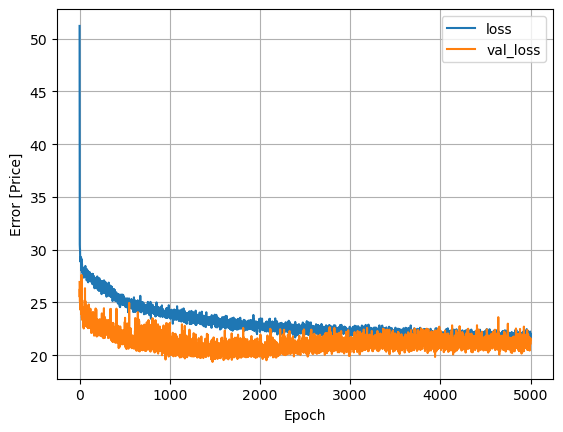

In [129]:
plot_loss(history)

In [57]:
print(history.history['val_loss'][-1])
print(history.history['loss'][-1])

246.16619873046875
129.4387664794922


In [58]:
test_results = {}

In [118]:
test_results['mape_a_0.01_dropout_0.2_e_10000'] = price_reduction_model.evaluate(test_features, test_labels, verbose=0)

In [119]:
test_results

{'a_0.01_dropout_0.0_e_1000': 144.45884704589844,
 'mape_a_0.01_dropout_0.0_e_1000': 464.60943603515625}

In [61]:
test_labels.describe()

count     1766.000000
mean      2257.167044
std       1379.296506
min        160.000000
25%       1499.250000
50%       2090.000000
75%       2770.000000
max      26000.000000
Name: Price, dtype: float64

In [94]:
predictions = price_reduction_model.predict(test_features)
true_price = np.array(test_labels).reshape(-1,1)
#predictions = price_reduction_model.predict(train_features)
#true_price = np.array(train_labels).reshape(-1,1)
error = abs(predictions-true_price)
print(error.sum()/error.shape[0])
#test_features.iloc[0]

56/56 [==============================] - 0s 3ms/step
183373.7245715045


56/56 [==============================] - 0s 2ms/step


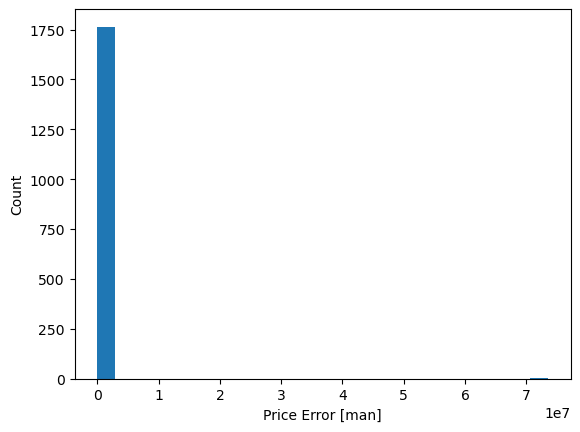

In [130]:
test_predictions = price_reduction_model.predict(test_features).flatten()
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Price Error [man]')
_ = plt.ylabel('Count')

In [102]:
np.max(test_predictions)

161714850.0

In [122]:
for i, p in enumerate(test_predictions):
    if p>100000:
        print(i, test_predictions[i], test_labels.iloc[i])

202 13956125.0 3480
998 13956125.0 3480


In [107]:
print(test_features.iloc[202])
print(test_labels.iloc[202])

Latitude                   33.609867
Longitude                 130.441696
Area m2                   100.560000
Balcony m2                 15.600000
Construction year        1996.000000
Floor                       6.000000
Highest floor               9.000000
Closest station (min)       8.000000
Number of stations          3.000000
1DK                         0.000000
1K                          0.000000
1LDK                        0.000000
1R                          0.000000
2DK                         0.000000
2K                          0.000000
2LDK                        0.000000
2LK                         0.000000
3DK                         0.000000
3K                          0.000000
3LDK                        0.000000
3LK                         1.000000
4DK                         0.000000
4K                          0.000000
4LDK                        0.000000
5DK                         0.000000
5LDK                        0.000000
HPC                         0.000000
P

In [111]:
price_reduction_model.save('price_estimation_loss_mae_a_0.01_dropout_0.0_e_1000')

INFO:tensorflow:Assets written to: price_estimation_loss_mae_a_0.01_dropout_0.0_e_1000\assets
